In [7]:
# NEED TO USE TADA_V2 kernel to be able to load the modles
import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns

import os

from Model import ADModel_three_state, ADModel_three_state_abund, ADModel_two_state, ADModel_two_state_abund, ADModel_act, ADModel_abund
from Data import DataReader, SplitData, FastTensorDataLoader

In [119]:
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

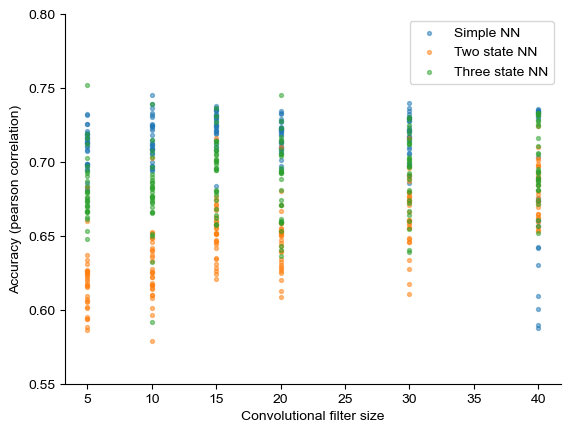

In [ ]:
import re
data_three_state = pd.read_csv("../results/results_3_state_repeats.csv")

data_two_state = pd.read_csv("../results/results_2_state_repeats.csv")

data_simple_abund = pd.read_csv("../results/results_simple_abund_repeats.csv")

data_simple_act = pd.read_csv("../results/results_simple_act_repeats.csv")

plt.scatter(data_simple_act[" kernel_size"], data_simple_act["Rs1_act_val"], label="Simple NN", s=8, alpha=0.5)

pattern = r"_ak(\d+)_"
data_two_state["abund_kernel_size"] = [re.search(pattern, name).group(1) for name in data_two_state["model_name"]]
plt.scatter(data_two_state[" kernel_size"], data_two_state["Rs1_act_val"], label="Two state NN", s=8, alpha=0.5)


data_three_state["abund_kernel_size"] = [re.search(pattern, name).group(1) for name in data_three_state["model_name"]]
plt.scatter(data_three_state[" kernel_size"], data_three_state["Rs1_act_val"], label="Three state NN", s=8, alpha=0.5)



plt.xlabel("Convolutional filter size")
plt.ylabel("Accuracy (pearson correlation)")

plt.legend()
plt.ylim(0.55, 0.8)

axs = plt.gca()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

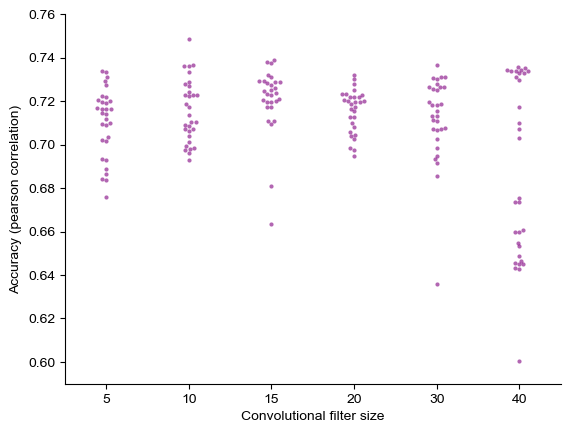

In [43]:
import re


data_simple_act = pd.read_csv("../results/results_simple_act_repeats.csv")

# sns.violinplot(x=data_simple_act[" kernel_size"], y=data_simple_act["Rs1_act_val"],color="black", fill=False, inner=None)
sns.swarmplot(x=data_simple_act[" kernel_size"], y=data_simple_act["Rs1_act_val"], size=3, color="purple", alpha=0.6)


plt.xlabel("Convolutional filter size")
plt.ylabel("Accuracy (pearson correlation)")

# plt.legend()
plt.ylim(0.59, 0.76)

axs = plt.gca()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

plt.savefig("../figures/seed_variation_simple_act.png")

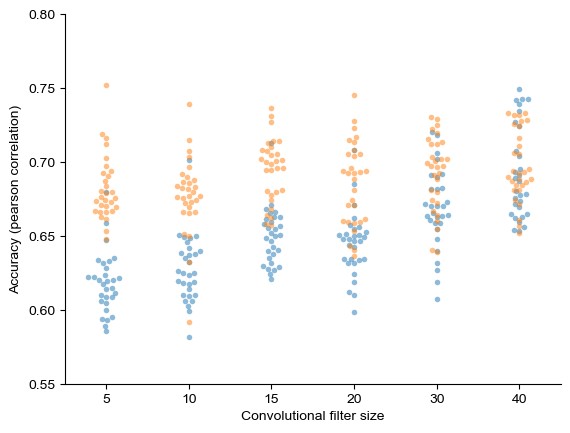

In [60]:
import re
data_three_state = pd.read_csv("../results/results_3_state_repeats.csv")

data_two_state = pd.read_csv("../results/results_2_state_repeats.csv")

data_simple_abund = pd.read_csv("../results/results_simple_abund_repeats.csv")

data_simple_act = pd.read_csv("../results/results_simple_act_repeats.csv")

# sns.swarmplot(x=data_simple_act[" kernel_size"], y=data_simple_act["Rs1_act_val"], size=4, alpha=0.5, color='purple')

pattern = r"_ak(\d+)_"
data_two_state["abund_kernel_size"] = [re.search(pattern, name).group(1) for name in data_two_state["model_name"]]
sns.swarmplot(x=data_two_state[" kernel_size"], y=data_two_state["Rs1_act_val"], size=4, alpha=0.5)


data_three_state["abund_kernel_size"] = [re.search(pattern, name).group(1) for name in data_three_state["model_name"]]
sns.swarmplot(x=data_three_state[" kernel_size"], y=data_three_state["Rs1_act_val"], size=4, alpha=0.5)



plt.xlabel("Convolutional filter size")
plt.ylabel("Accuracy (pearson correlation)")

# plt.legend()
plt.ylim(0.55, 0.8)

axs = plt.gca()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

In [62]:
size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_three_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

for index in data_three_state.index:
    K = data_three_state.loc[index, " kernel_size"]
    name = data_three_state.loc[index, "model_name"]
    ak = int(data_three_state.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K, ak))
    elif K == 10:
        models_10.append(load_model(name, K, ak))
    elif K == 15:
        models_15.append(load_model(name, K, ak))
    elif K == 20:
        models_20.append(load_model(name, K, ak))
    elif K == 30:
        models_30.append(load_model(name, K, ak))
    elif K == 40:
        models_40.append(load_model(name, K, ak))


In [349]:
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

# Weights preparation
def get_conv_weights(model, layer): 
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer):
    model_state_dict = model.state_dict()
    linear_weights = model_state_dict[layer].detach().numpy()
    return linear_weights


In [65]:
# Red often represents negative charges
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [66]:
def make_mean_variance_plots(conv_weights, kernel_size, filter_type=""):
    stacked_arrays = np.stack(conv_weights, axis=0)

    mean_array = np.mean(stacked_arrays, axis=0)
    variance_array = np.var(stacked_arrays, axis=0)

    lim1 = max([abs(w) for w in mean_array.flatten()])
    lim2 = max([abs(w) for w in variance_array.flatten()])


    fig, axs = plt.subplots(1,2, figsize=(10,5))
    ax1 = axs[0]
    ax2 = axs[1]

    im1 = ax1.imshow(mean_array.T, cmap=custom_cmap, aspect='auto',vmin=-lim1,vmax=lim1)
    ax1.set_yticks(range(20), amino_acids)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=1))

    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='both', which='major', labelsize=8) 

    im2 = ax2.imshow(variance_array.T, cmap=custom_cmap, aspect='auto',vmin=-lim2,vmax=lim2)
    ax2.set_yticks(range(20), amino_acids)  # Label x-axis with column names
    ax2.set_xticks(np.arange(kernel_size, step=1))

    for ytic in ax2.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax2.tick_params(axis='both', which='major', labelsize=8) 

    ax1.set_title(f"Mean of {filter_type} Convolutional Filters", fontsize=12)
    ax2.set_title(f"Variance of {filter_type} Convolution Filters", fontsize=12)

    fig.colorbar(im1,ax=ax1, orientation='horizontal')
    fig.colorbar(im2,ax=ax2, orientation='horizontal')


In [71]:
def make_mean_plots(conv_weights, kernel_size, filter_type=""):
    stacked_arrays = np.stack(conv_weights, axis=0)

    mean_array = np.mean(stacked_arrays, axis=0)

    lim1 = max([abs(w) for w in mean_array.flatten()])


    fig, axs = plt.subplots(1,1, figsize=(5,5))
    ax1 = axs

    im1 = ax1.imshow(mean_array.T, cmap=custom_cmap, aspect='auto',vmin=-lim1,vmax=lim1)
    ax1.set_yticks(range(20), amino_acids)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=1))

    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='both', which='major', labelsize=8) 

    ax1.set_title(f"Mean of {filter_type} Convolutional Filters", fontsize=12)

    fig.colorbar(im1,ax=ax1, orientation='horizontal')


In [390]:
def make_row_plot(fig, kernel_size, model_conv1, model_linear1, row, lim, height_ratios, num_rows):

    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    im1 = ax1.imshow(model_conv1, cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(amino_acids)), amino_acids)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 

    ax2.bar(range(len(model_linear1)), model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)
    ax2.spines['bottom'].set_bounds(-1, len(model_linear1))
    
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

def get_linear_weights(model, layer):
    model_state_dict = model.state_dict()
    linear_weights = model_state_dict[layer].detach().numpy()
    return linear_weights


In [391]:
def get_mean_weights(model_list): 
    conv_weights = []
    linear_weight_ls = []
    conv_array_neg = []
    linear_array_neg = []
    
    for model in model_list:
        linear_weights = get_linear_weights(model, "linear1.weight")
        if (linear_weights.sum() < 0):
            # print(linear_weights)
            conv_array_neg.append(get_conv_weights(model, "conv1.weight").values)
            linear_array_neg.append(linear_weights)
        else: 
            conv_weight = get_conv_weights(model, "conv1.weight").values
            linear_weight_ls.append(linear_weights)
            conv_weights.append(conv_weight)

    stacked_arrays = np.stack(conv_weights, axis=0)
    mean_conv_array = np.mean(stacked_arrays, axis=0)

    stacked_arrays = np.stack(linear_weight_ls, axis=0)
    mean_linear_array = np.mean(linear_weight_ls, axis=0)

    if len(conv_array_neg) > 0:
        stacked_arrays = np.stack(conv_array_neg, axis=0)
        mean_conv_array_neg = np.mean(stacked_arrays, axis=0)
        stacked_arrays = np.stack(linear_array_neg, axis=0)
        mean_linear_array_neg = np.mean(linear_array_neg, axis=0)
    else: 
        mean_conv_array_neg = np.array([])
        mean_linear_array_neg = np.array([])

    return mean_conv_array, mean_linear_array.flatten(), mean_conv_array_neg, mean_linear_array_neg.flatten()

# Three state model

In [392]:
def get_mean_weights_K2(model_list): 
    conv_weights = []
    linear_weight_ls = []
    conv_array_neg = []
    linear_array_neg = []
    
    for model in model_list:
        linear_weights = get_linear_weights(model, "linear2.weight")
        if (linear_weights.sum() < 0):
            # print(linear_weights)
            conv_array_neg.append(get_conv_weights(model, "conv2.weight").values)
            linear_array_neg.append(linear_weights)
        else: 
            conv_weight = get_conv_weights(model, "conv2.weight").values
            linear_weight_ls.append(linear_weights)
            conv_weights.append(conv_weight)

    stacked_arrays = np.stack(conv_weights, axis=0)
    mean_conv_array = np.mean(stacked_arrays, axis=0)

    stacked_arrays = np.stack(linear_weight_ls, axis=0)
    mean_linear_array = np.mean(linear_weight_ls, axis=0)

    if len(conv_array_neg) > 0:
        stacked_arrays = np.stack(conv_array_neg, axis=0)
        mean_conv_array_neg = np.mean(stacked_arrays, axis=0)
        stacked_arrays = np.stack(linear_array_neg, axis=0)
        mean_linear_array_neg = np.mean(linear_array_neg, axis=0)
    else: 
        mean_conv_array_neg = np.array([])
        mean_linear_array_neg = np.array([])

    return mean_conv_array, mean_linear_array.flatten(), mean_conv_array_neg, mean_linear_array_neg.flatten()

In [393]:
size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_three_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_three_state_filtered = data_three_state[data_three_state[" Rsq_abund_val"] > 0.15]

for index in data_three_state_filtered.index:
    K = data_three_state_filtered.loc[index, " kernel_size"]
    name = data_three_state_filtered.loc[index, "model_name"]
    ak = int(data_three_state_filtered.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K, ak))
    elif K == 10:
        models_10.append(load_model(name, K, ak))
    elif K == 15:
        models_15.append(load_model(name, K, ak))
    elif K == 20:
        models_20.append(load_model(name, K, ak))
    elif K == 30:
        models_30.append(load_model(name, K, ak))
    elif K == 40:
        models_40.append(load_model(name, K, ak))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


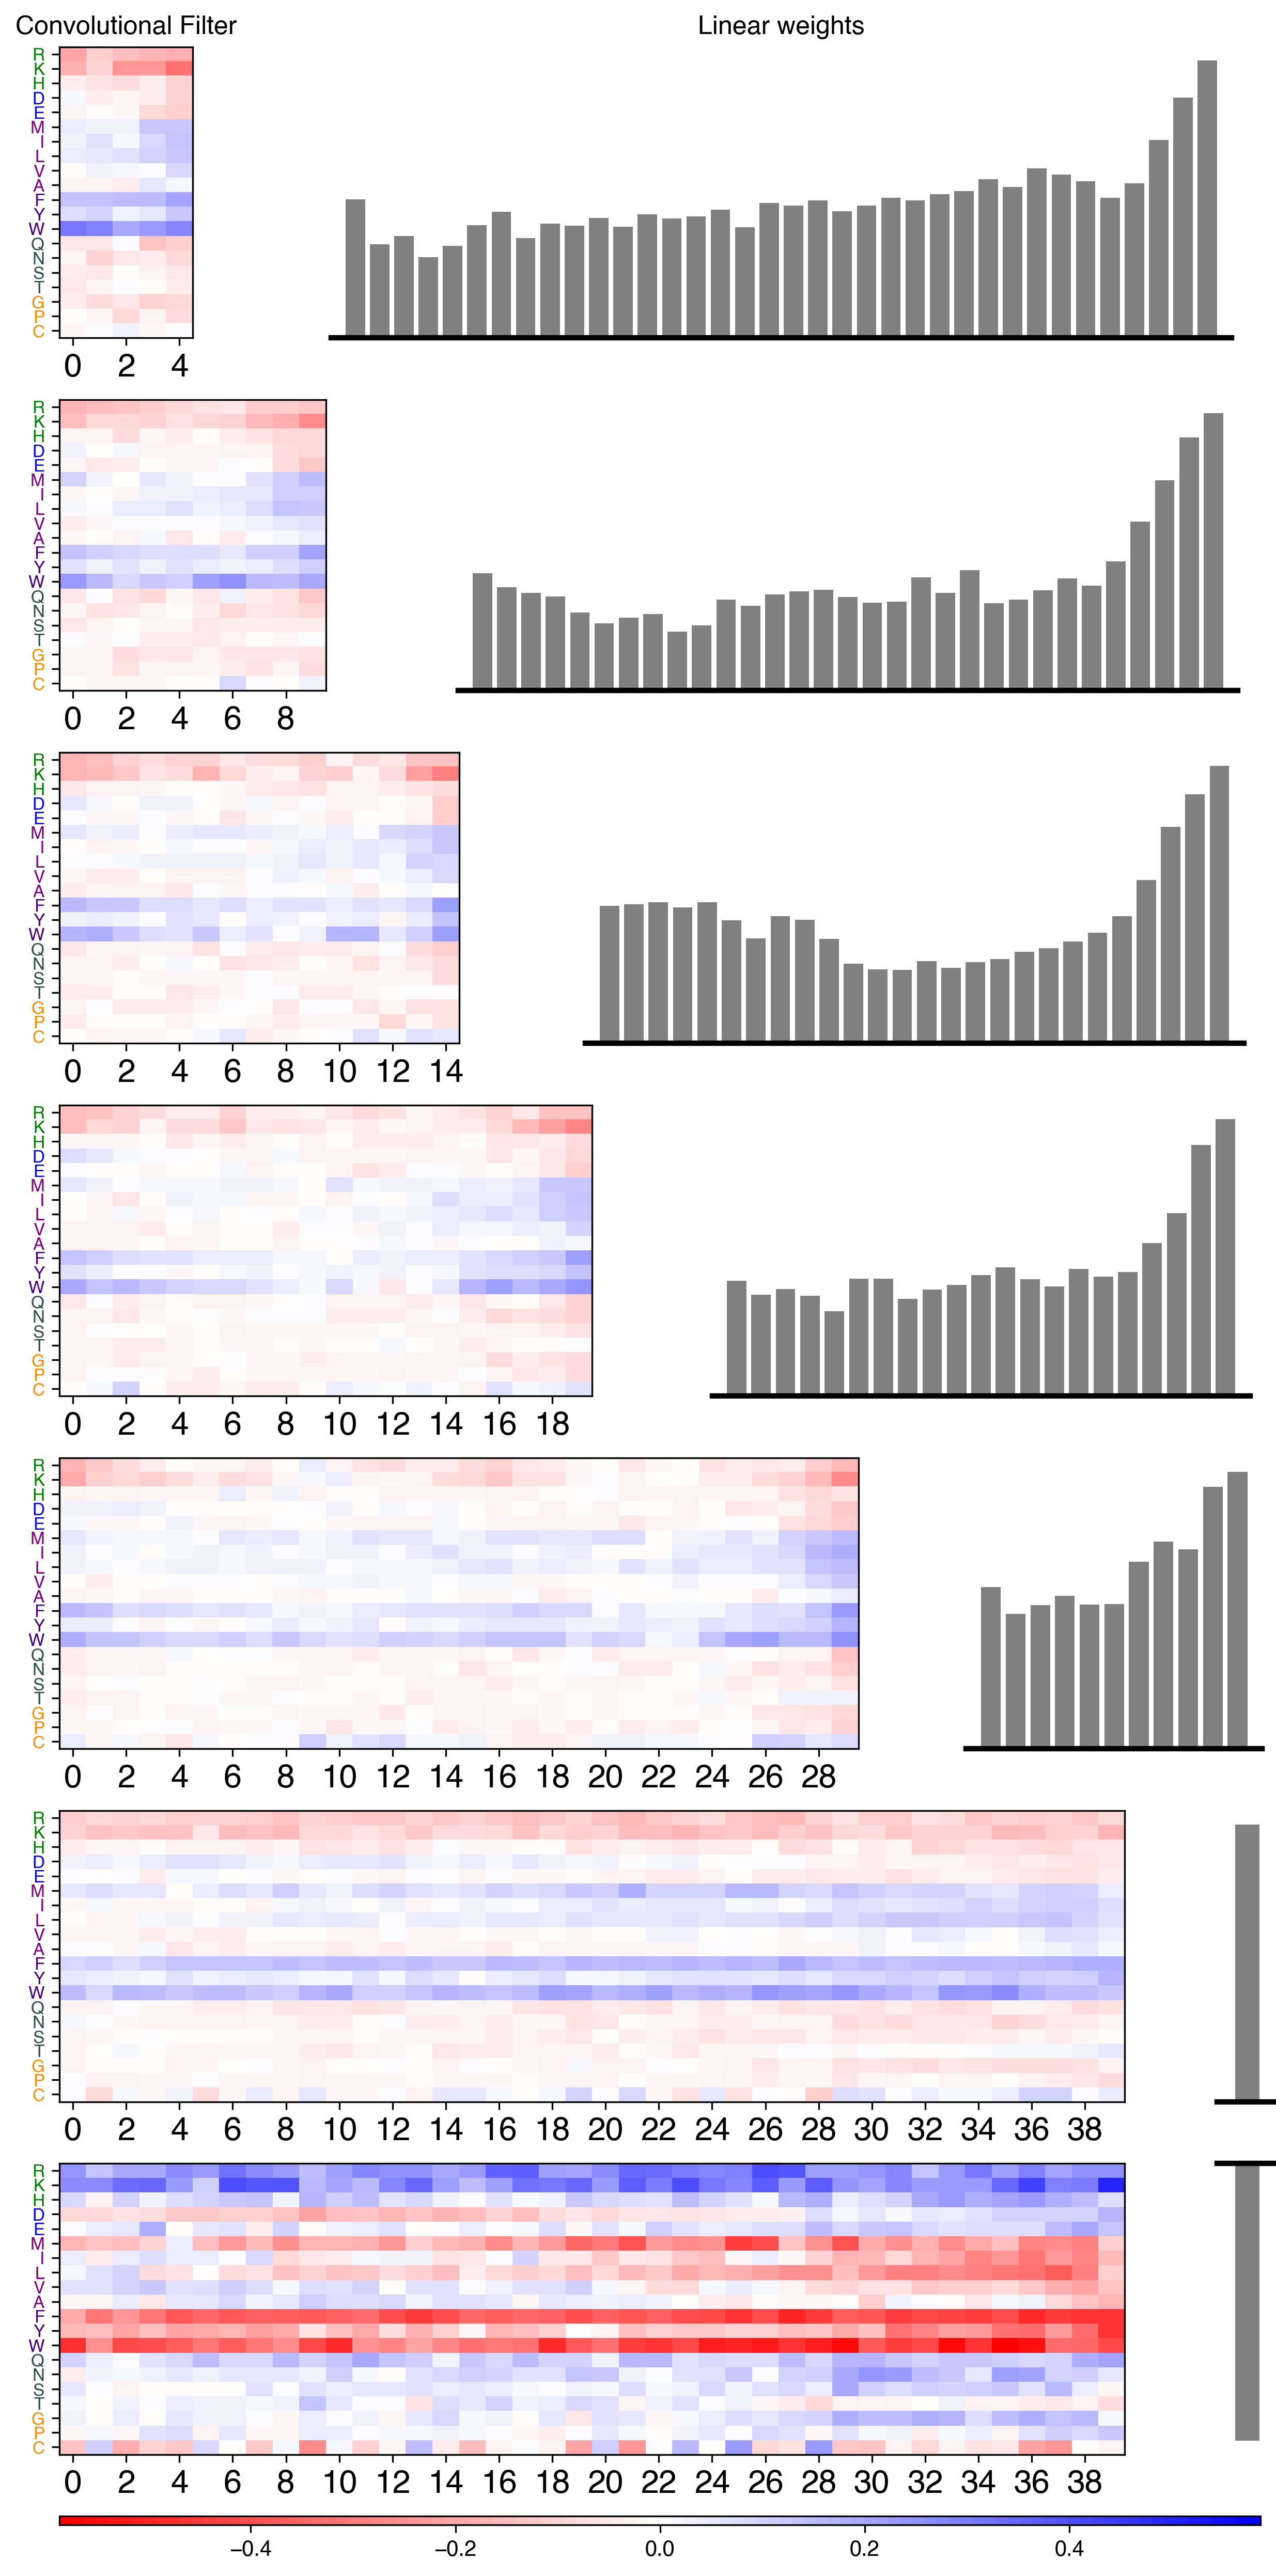

In [396]:
num_rows = 7

conv1_weights_5,  linear_weights_5,  neg_conv1_weights_5,   neg_linear_weights_5 = get_mean_weights(models_5)
conv1_weights_10, linear_weights_10, neg_conv1_weights_10,  neg_linear_weights_10 = get_mean_weights(models_10)
conv1_weights_15, linear_weights_15, neg_conv1_weights_15,  neg_linear_weights_15 = get_mean_weights(models_15)
conv1_weights_20, linear_weights_20, neg_conv1_weights_20,  neg_linear_weights_20 = get_mean_weights(models_20)
conv1_weights_30, linear_weights_30, neg_conv1_weights_30,  neg_linear_weights_30 = get_mean_weights(models_30)
conv1_weights_40, linear_weights_40, neg_conv1_weights_40,  neg_linear_weights_40 = get_mean_weights(models_40)


conv_weights = np.concatenate([conv1_weights_5.flatten(), conv1_weights_10.flatten(), conv1_weights_15.flatten(), conv1_weights_20.flatten(), conv1_weights_30.flatten(), conv1_weights_40.flatten(), neg_conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 5, conv1_weights_5.T, linear_weights_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 10, conv1_weights_10.T, linear_weights_10, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 15, conv1_weights_15.T, linear_weights_15, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 20, conv1_weights_20.T, linear_weights_20, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 30, conv1_weights_30.T, linear_weights_30, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 40, conv1_weights_40.T, linear_weights_40, 11, lim, height_ratios, num_rows)

make_row_plot(fig, 40, neg_conv1_weights_40.T, neg_linear_weights_40, 13, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/three_state_K1_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


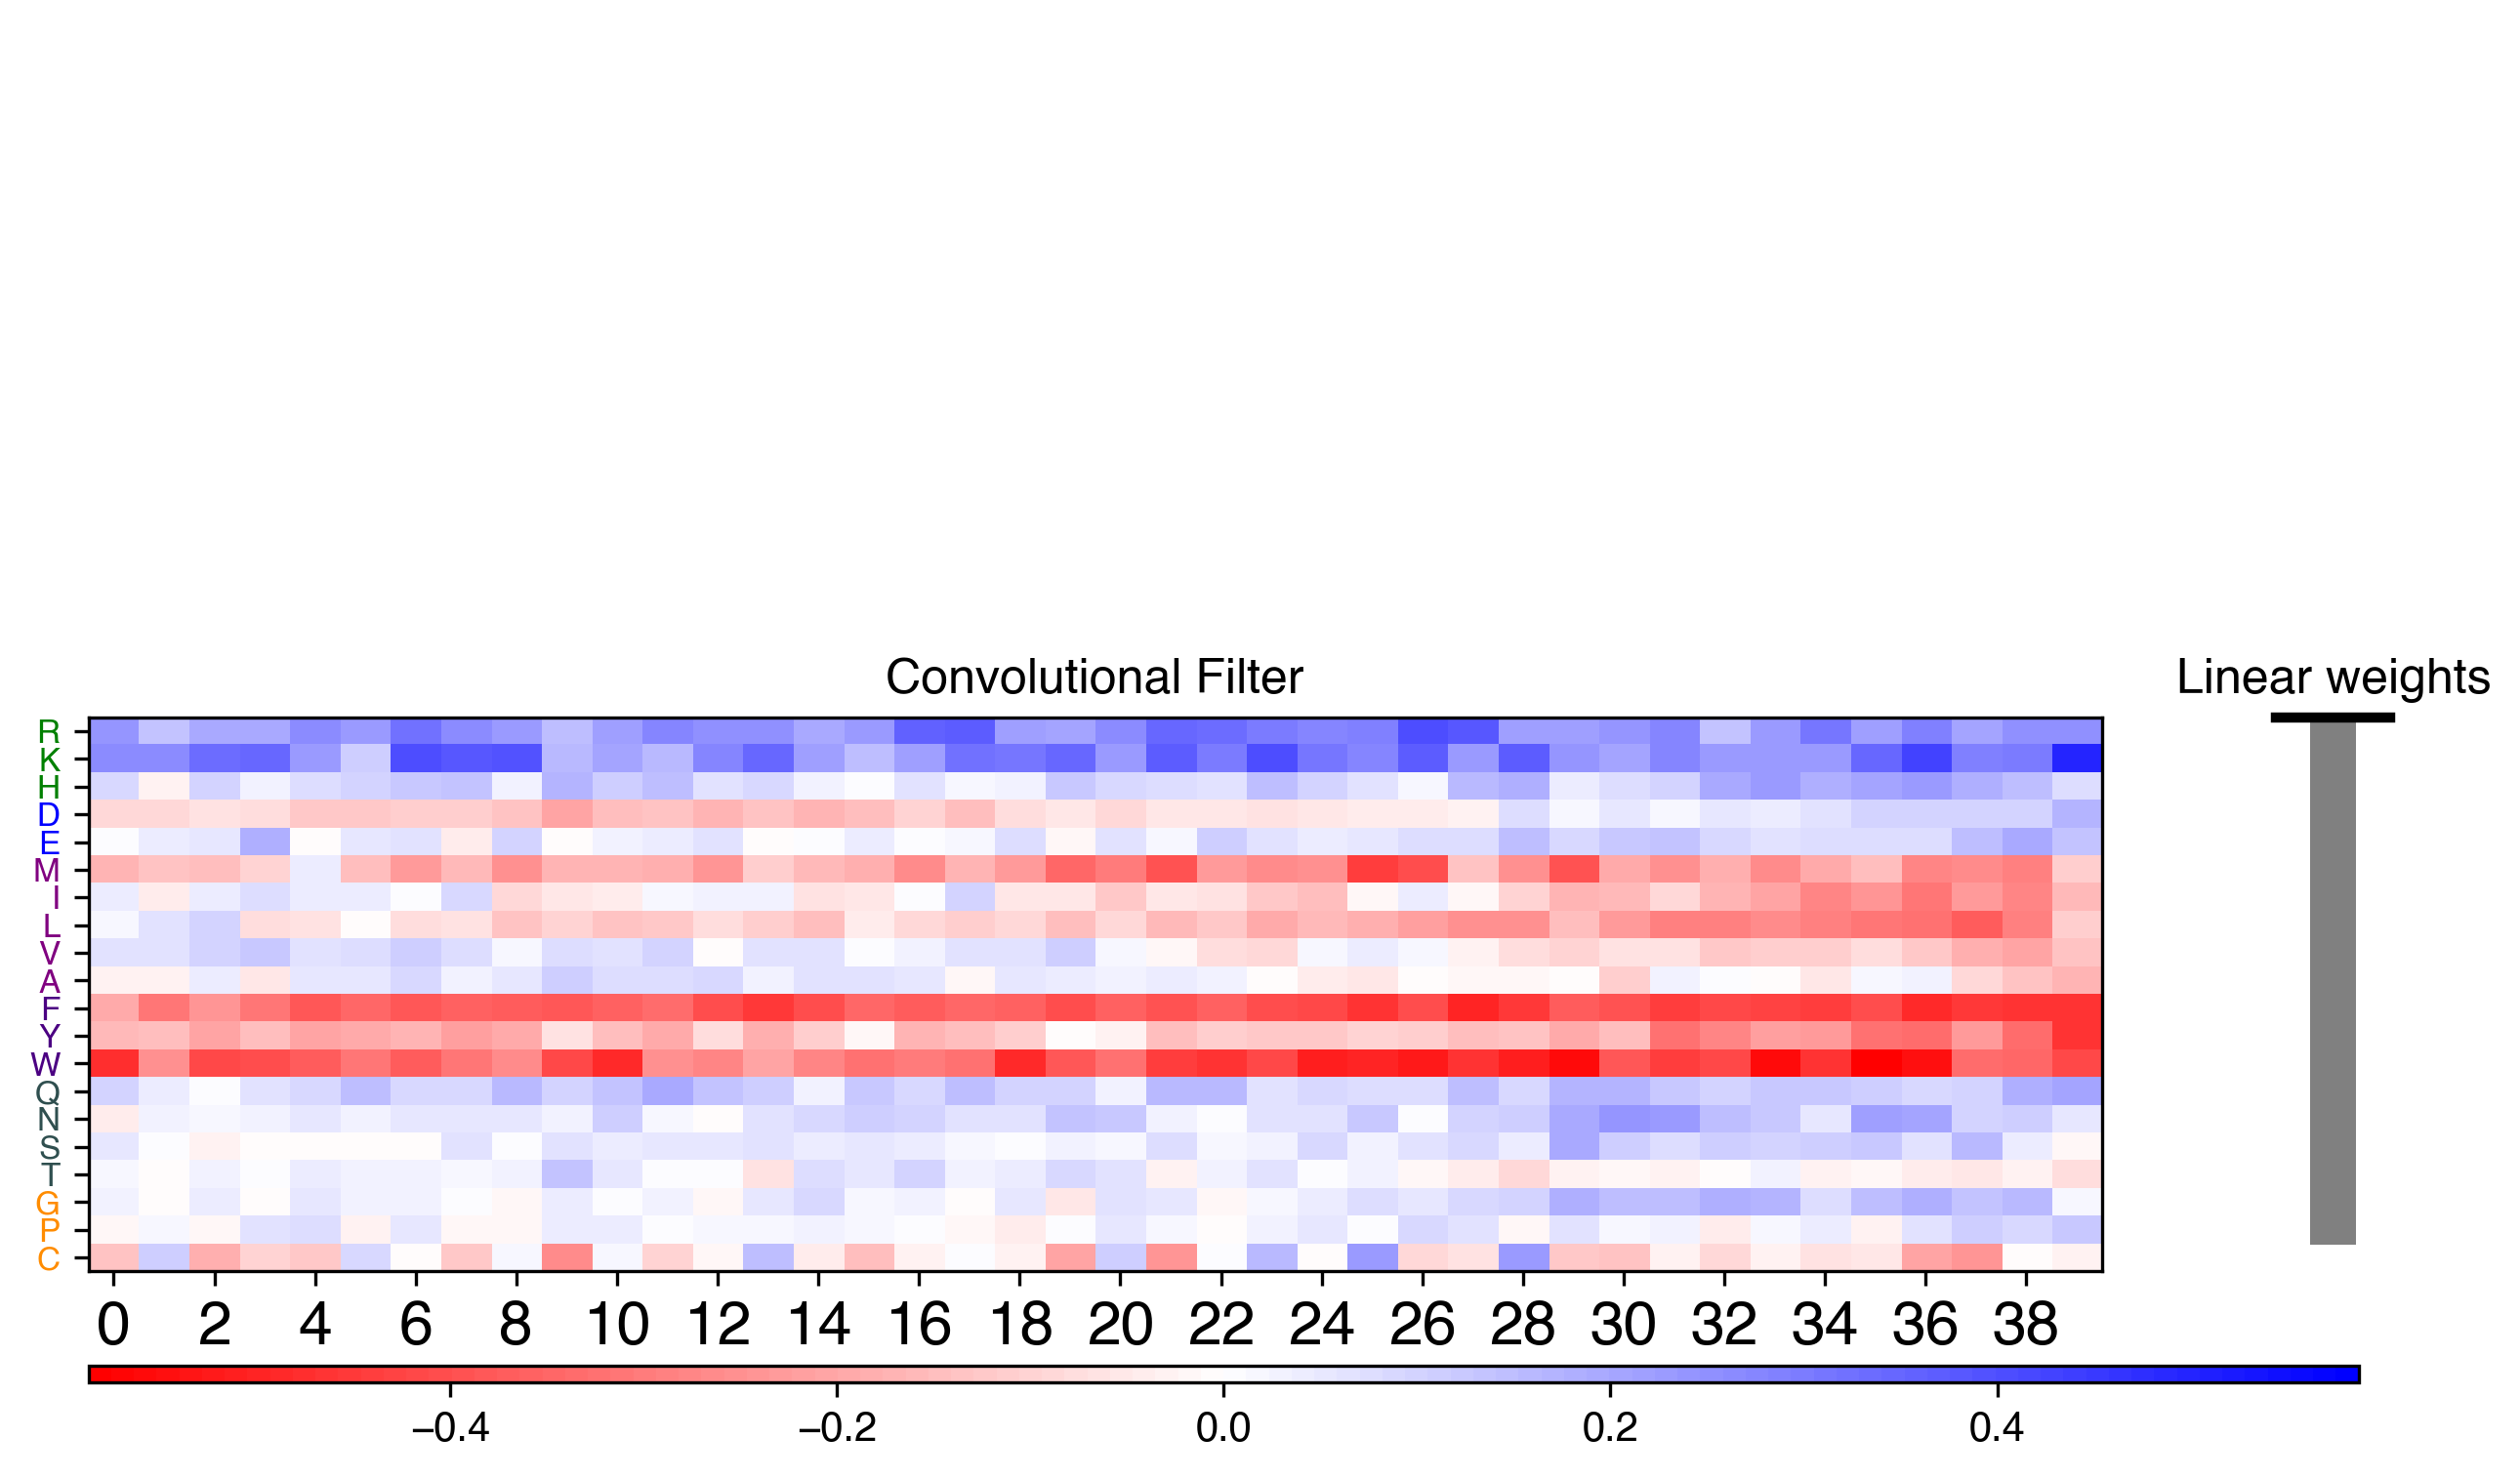

In [370]:
num_rows = 2

conv_weights = np.concatenate([neg_conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 40, neg_conv1_weights_40.T, neg_linear_weights_40, 3, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

# make_row_plot(fig, 20, neg_conv1_weights_20.T, neg_linear_weights_20, 3, lim, height_ratios, num_rows)
# make_row_plot(fig, 40, neg_conv1_weights_40.T, neg_linear_weights_40, 3, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/three_state_K1_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


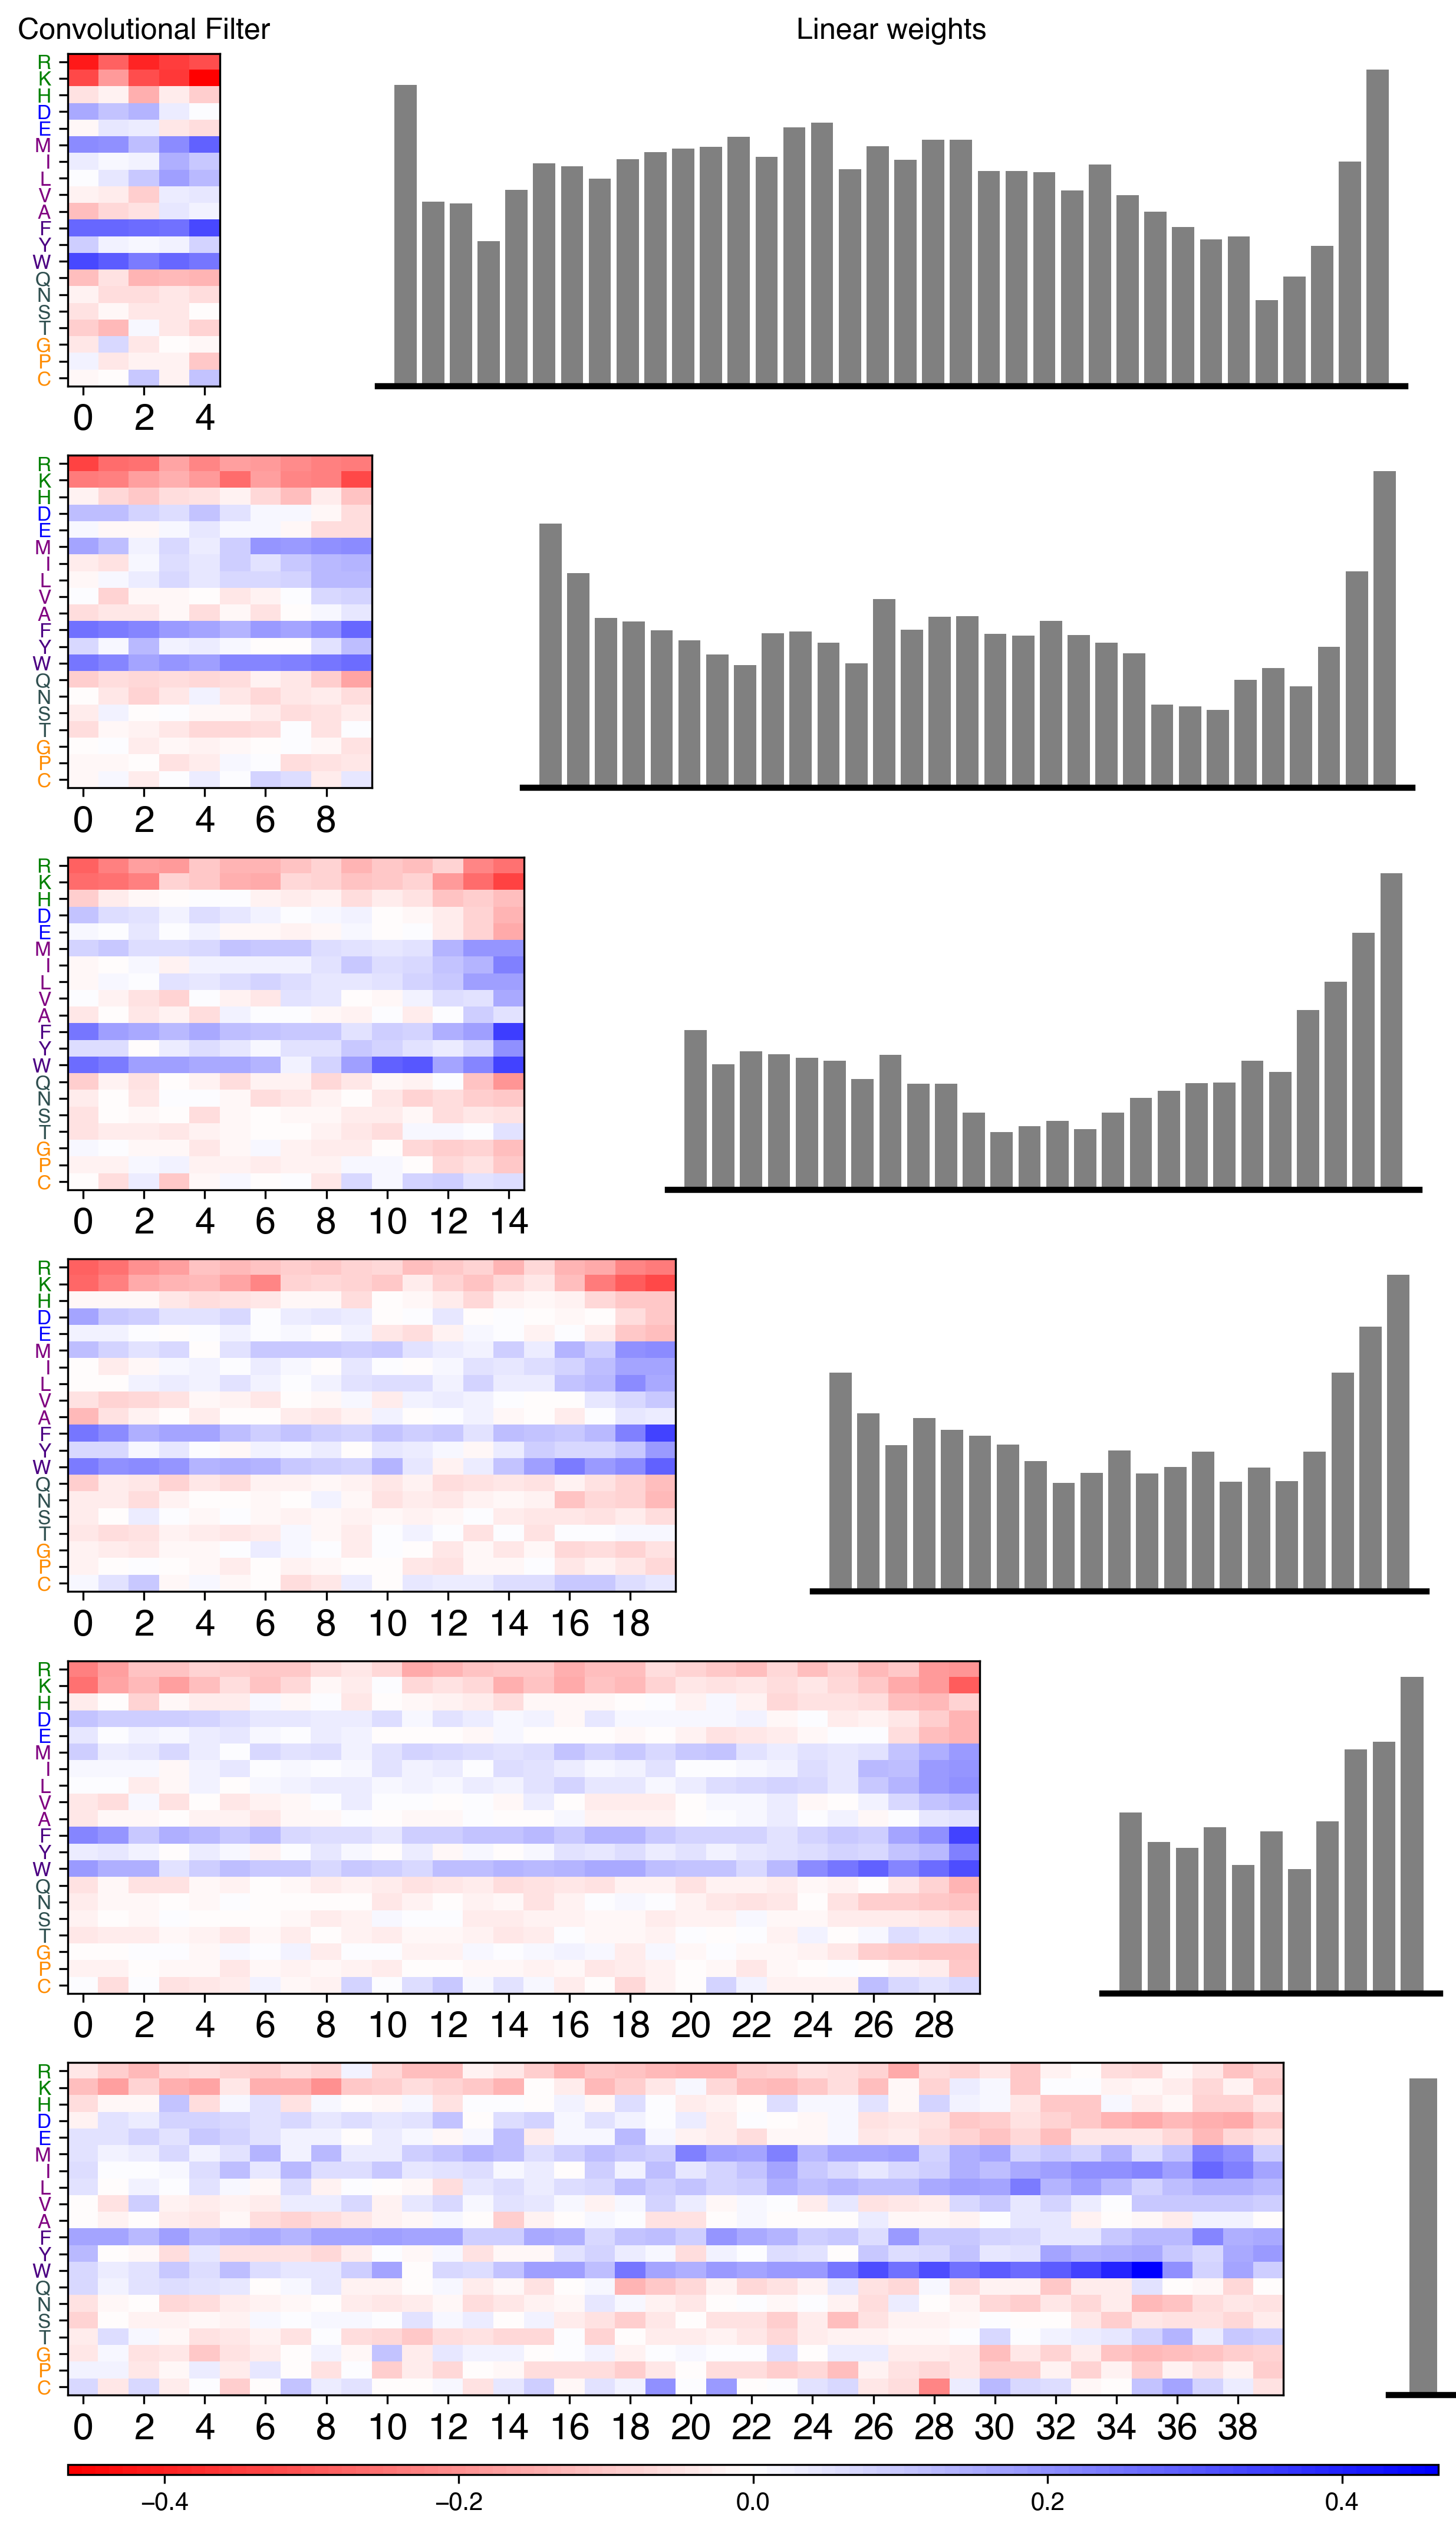

In [371]:
num_rows = 6

conv1_weights_5,  linear_weights_5,  neg_conv1_weights_5,   neg_linear_weights_5 = get_mean_weights_K2(models_5)
conv1_weights_10, linear_weights_10, neg_conv1_weights_10,  neg_linear_weights_10 = get_mean_weights_K2(models_10)
conv1_weights_15, linear_weights_15, neg_conv1_weights_15,  neg_linear_weights_15 = get_mean_weights_K2(models_15)
conv1_weights_20, linear_weights_20, neg_conv1_weights_20,  neg_linear_weights_20 = get_mean_weights_K2(models_20)
conv1_weights_30, linear_weights_30, neg_conv1_weights_30,  neg_linear_weights_30 = get_mean_weights_K2(models_30)
conv1_weights_40, linear_weights_40, neg_conv1_weights_40,  neg_linear_weights_40 = get_mean_weights_K2(models_40)


conv_weights = np.concatenate([conv1_weights_5.flatten(), conv1_weights_10.flatten(), conv1_weights_15.flatten(), conv1_weights_20.flatten(), conv1_weights_30.flatten(), conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 5, conv1_weights_5.T, linear_weights_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 10, conv1_weights_10.T, linear_weights_10, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 15, conv1_weights_15.T, linear_weights_15, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 20, conv1_weights_20.T, linear_weights_20, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 30, conv1_weights_30.T, linear_weights_30, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 40, conv1_weights_40.T, linear_weights_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/three_state_K2_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


# For two state

In [314]:
size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_two_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_two_state = data_two_state[data_two_state[" Rsq_abund_val"] > 0.15]

for index in data_two_state.index:
    K = data_two_state.loc[index, " kernel_size"]
    name = data_two_state.loc[index, "model_name"]
    ak = int(data_two_state.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K, ak))
    elif K == 10:
        models_10.append(load_model(name, K, ak))
    elif K == 15:
        models_15.append(load_model(name, K, ak))
    elif K == 20:
        models_20.append(load_model(name, K, ak))
    elif K == 30:
        models_30.append(load_model(name, K, ak))
    elif K == 40:
        models_40.append(load_model(name, K, ak))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


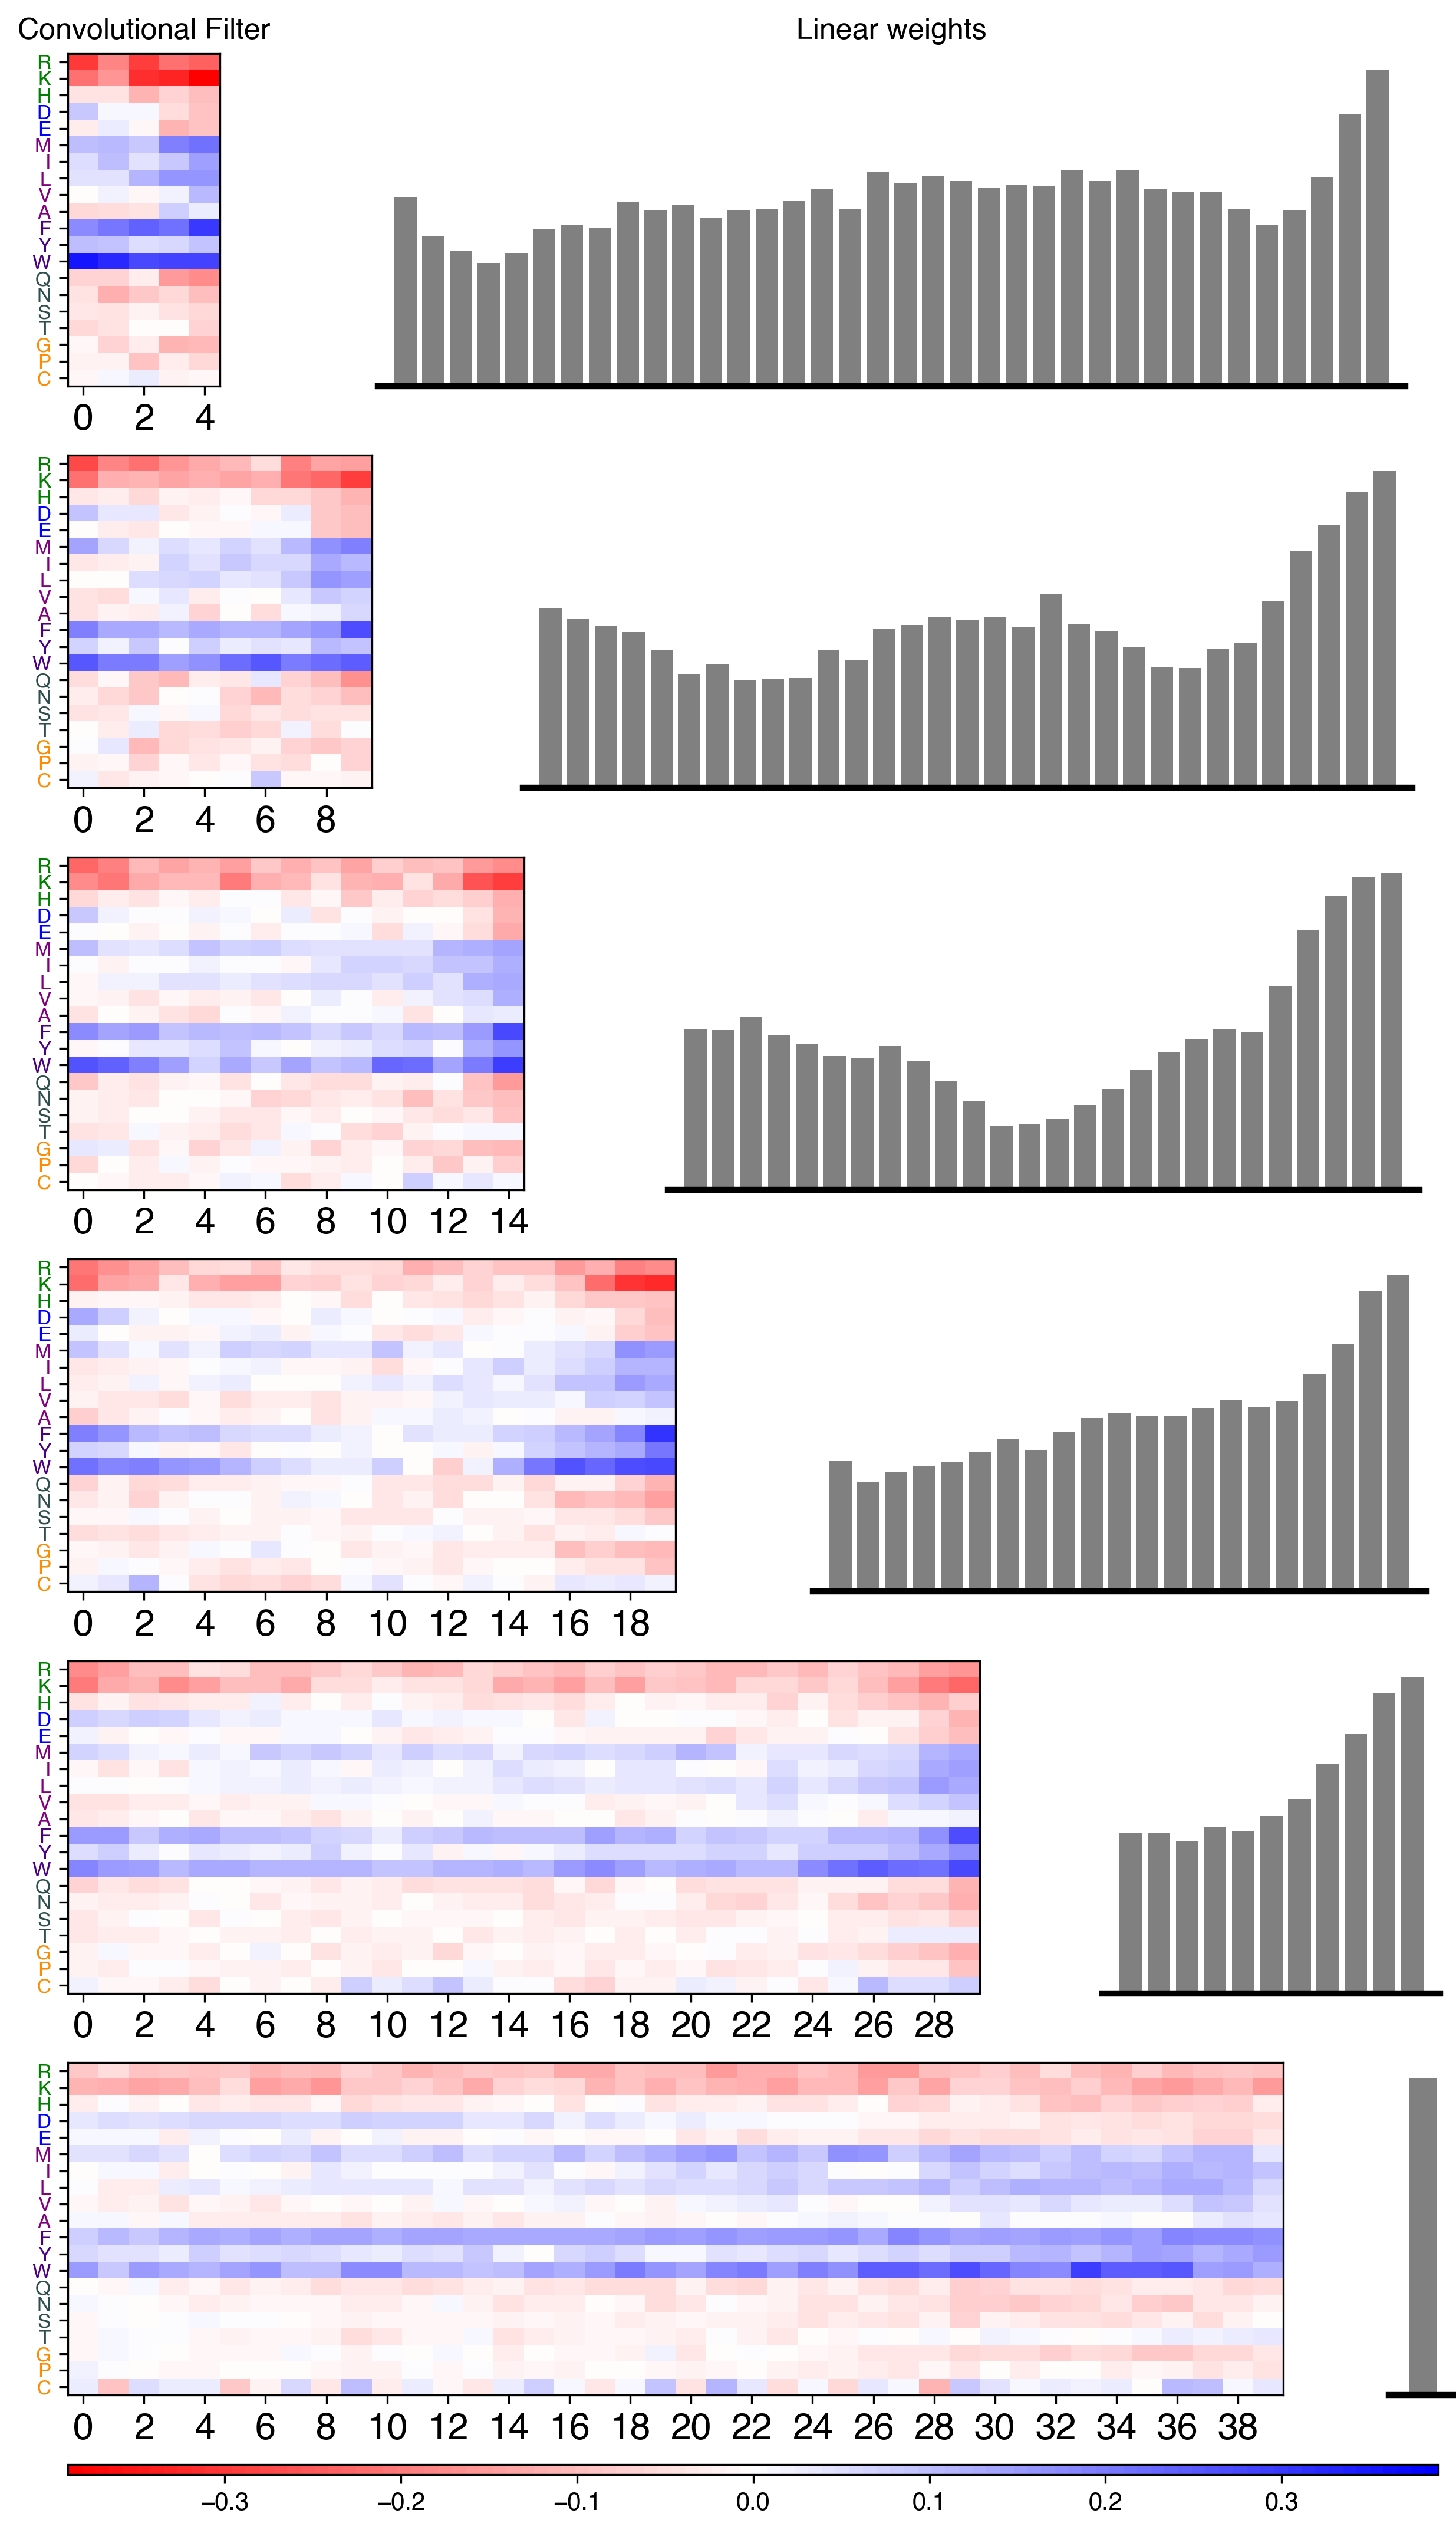

In [316]:
num_rows = 6

conv1_weights_5,  linear_weights_5,  neg_conv1_weights_5,   neg_linear_weights_5 = get_mean_weights(models_5)
conv1_weights_10, linear_weights_10, neg_conv1_weights_10,  neg_linear_weights_10 = get_mean_weights(models_10)
conv1_weights_15, linear_weights_15, neg_conv1_weights_15,  neg_linear_weights_15 = get_mean_weights(models_15)
conv1_weights_20, linear_weights_20, neg_conv1_weights_20,  neg_linear_weights_20 = get_mean_weights(models_20)
conv1_weights_30, linear_weights_30, neg_conv1_weights_30,  neg_linear_weights_30 = get_mean_weights(models_30)
conv1_weights_40, linear_weights_40, neg_conv1_weights_40,  neg_linear_weights_40 = get_mean_weights(models_40)


conv_weights = np.concatenate([conv1_weights_5.flatten(), conv1_weights_10.flatten(), conv1_weights_15.flatten(), conv1_weights_20.flatten(), conv1_weights_30.flatten(), conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 5, conv1_weights_5.T, linear_weights_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 10, conv1_weights_10.T, linear_weights_10, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 15, conv1_weights_15.T, linear_weights_15, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 20, conv1_weights_20.T, linear_weights_20, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 30, conv1_weights_30.T, linear_weights_30, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 40, conv1_weights_40.T, linear_weights_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/two_state_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


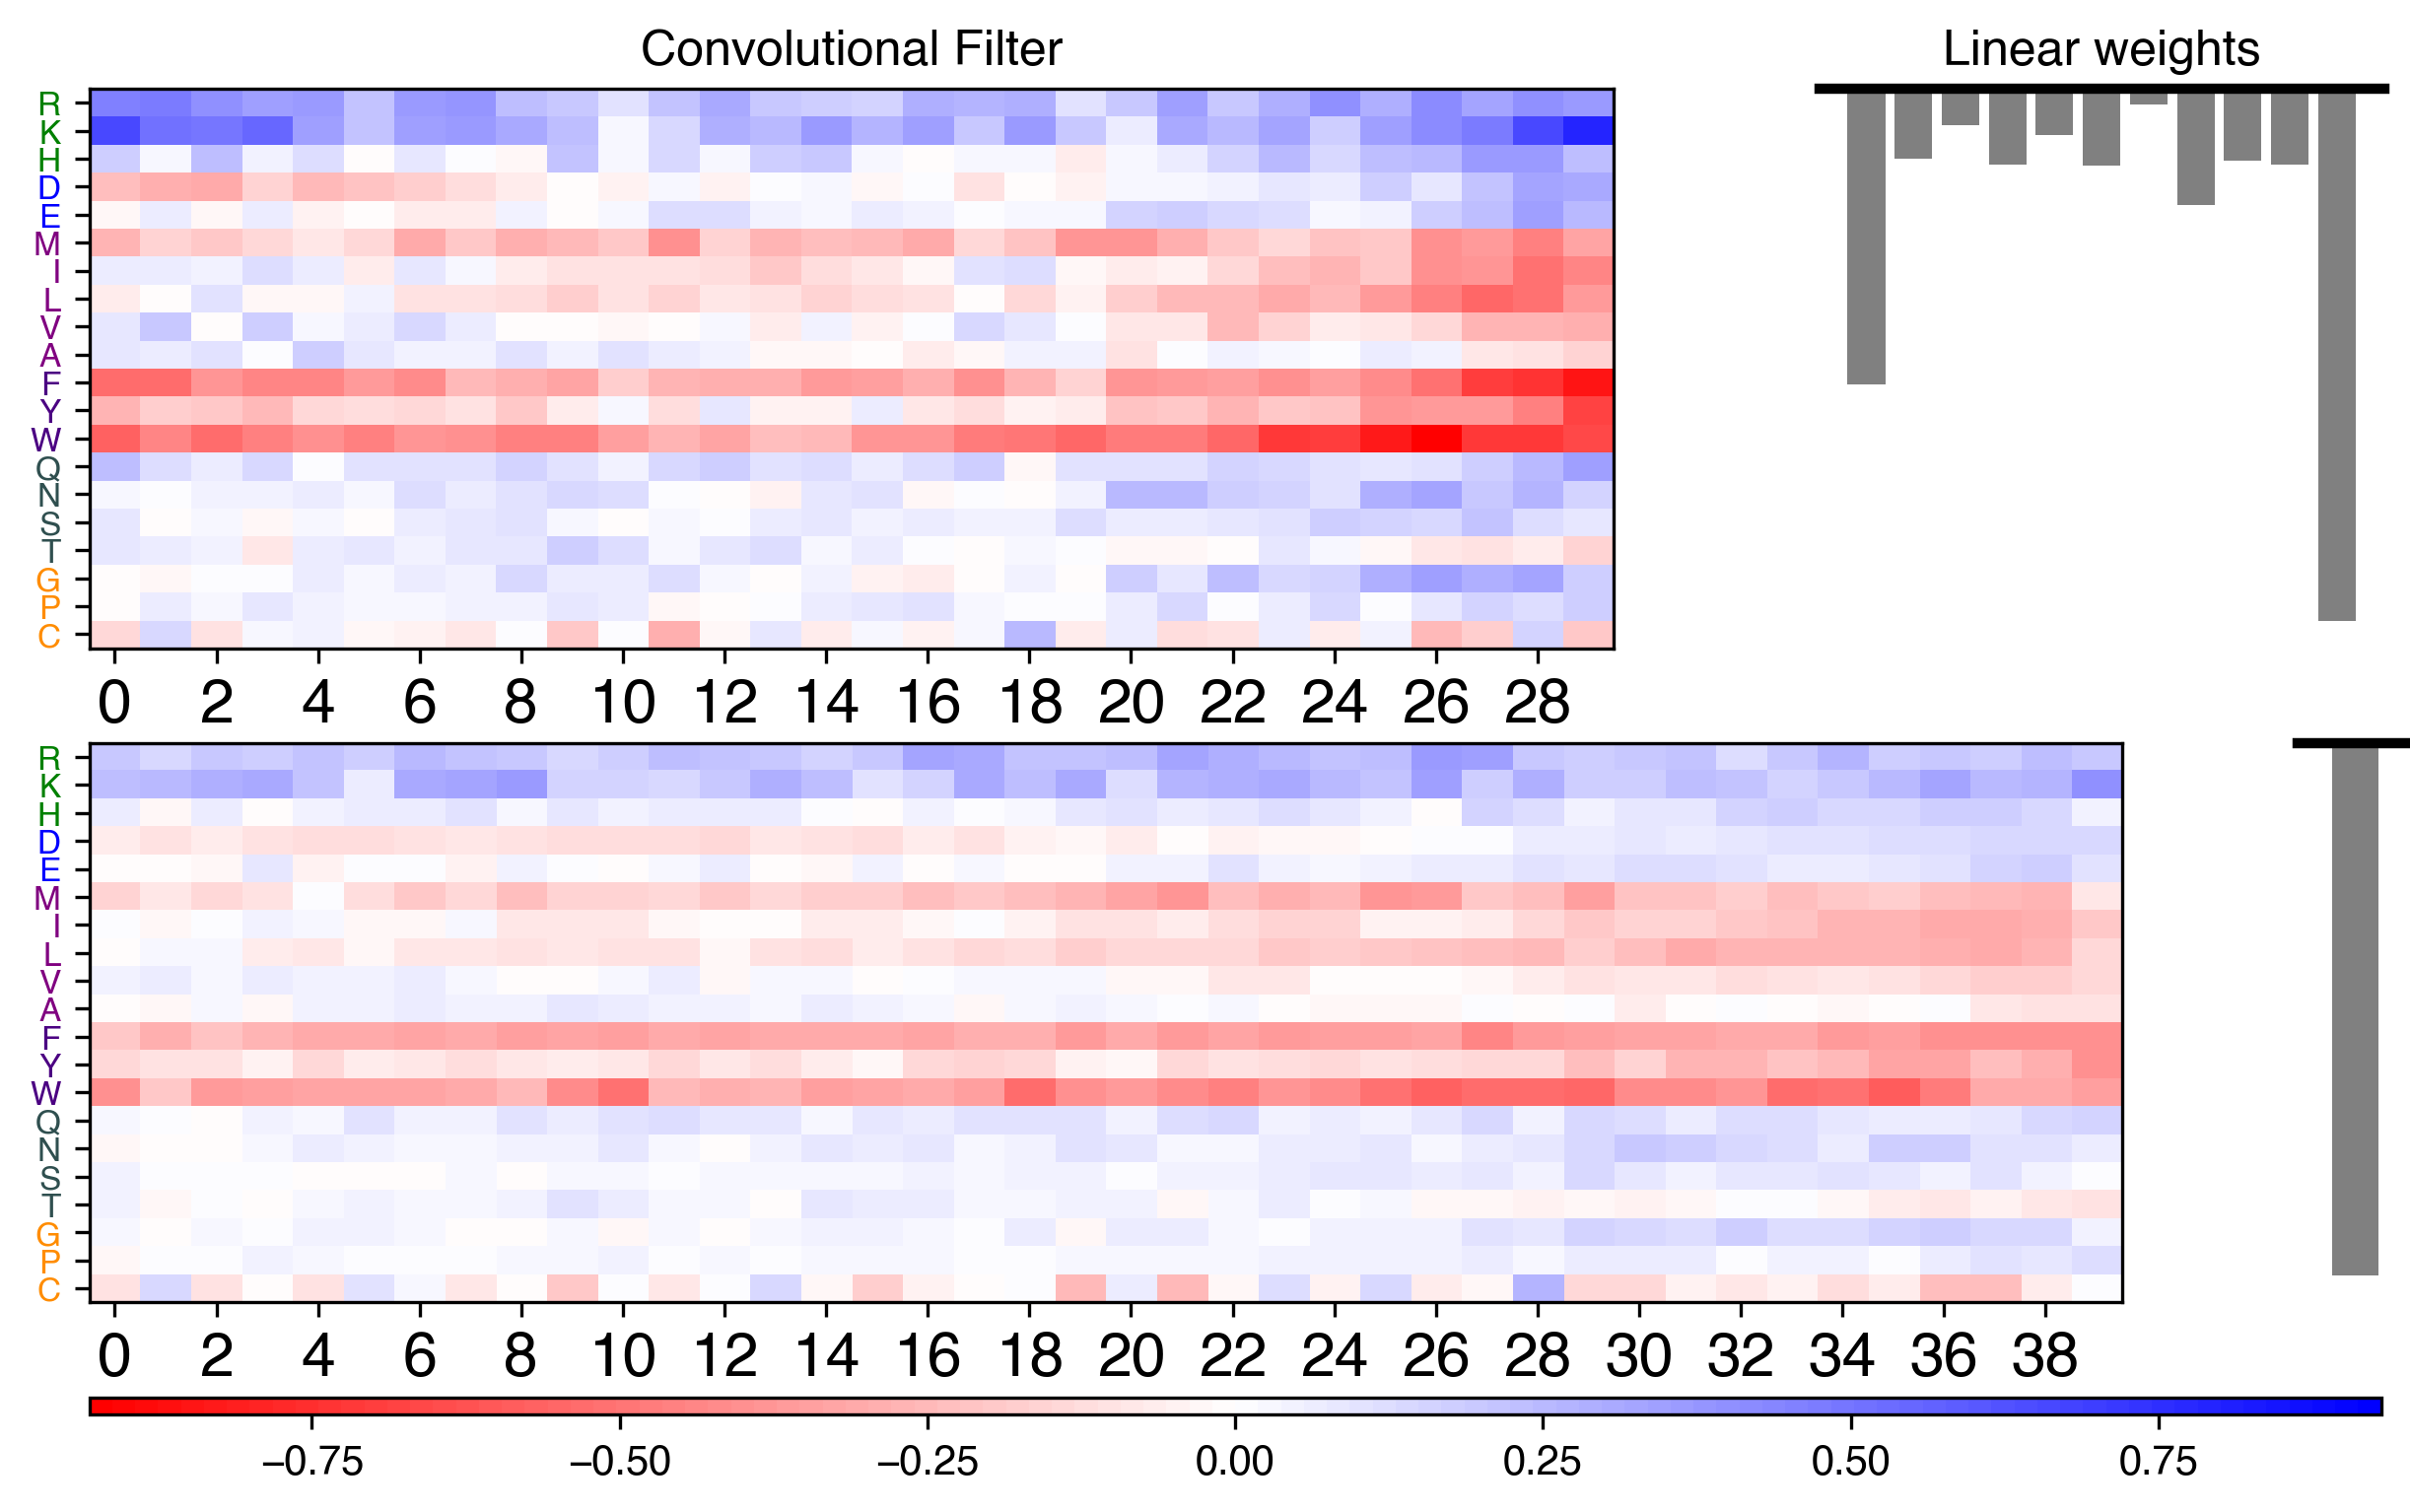

In [322]:
num_rows = 2

conv_weights = np.concatenate([neg_conv1_weights_30.flatten(), neg_conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 30, neg_conv1_weights_30.T, neg_linear_weights_30, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

# make_row_plot(fig, 20, neg_conv1_weights_20.T, neg_linear_weights_20, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 40, neg_conv1_weights_40.T, neg_linear_weights_40, 3, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/two_state_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# For simple act

In [267]:
size = (1,40,20)
import torch 

def load_model(name, k):
    model = ADModel_act(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_simple_act_filtered = data_simple_act[data_simple_act["Rs1_act_val"] > 0.6]

for index in data_simple_act_filtered.index:
    K = data_simple_act_filtered.loc[index, " kernel_size"]
    name = data_simple_act_filtered.loc[index, "model_name"]
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K))
    elif K == 10:
        models_10.append(load_model(name, K))
    elif K == 15:
        models_15.append(load_model(name, K))
    elif K == 20:
        models_20.append(load_model(name, K))
    elif K == 30:
        models_30.append(load_model(name, K))
    elif K == 40:
        models_40.append(load_model(name, K))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


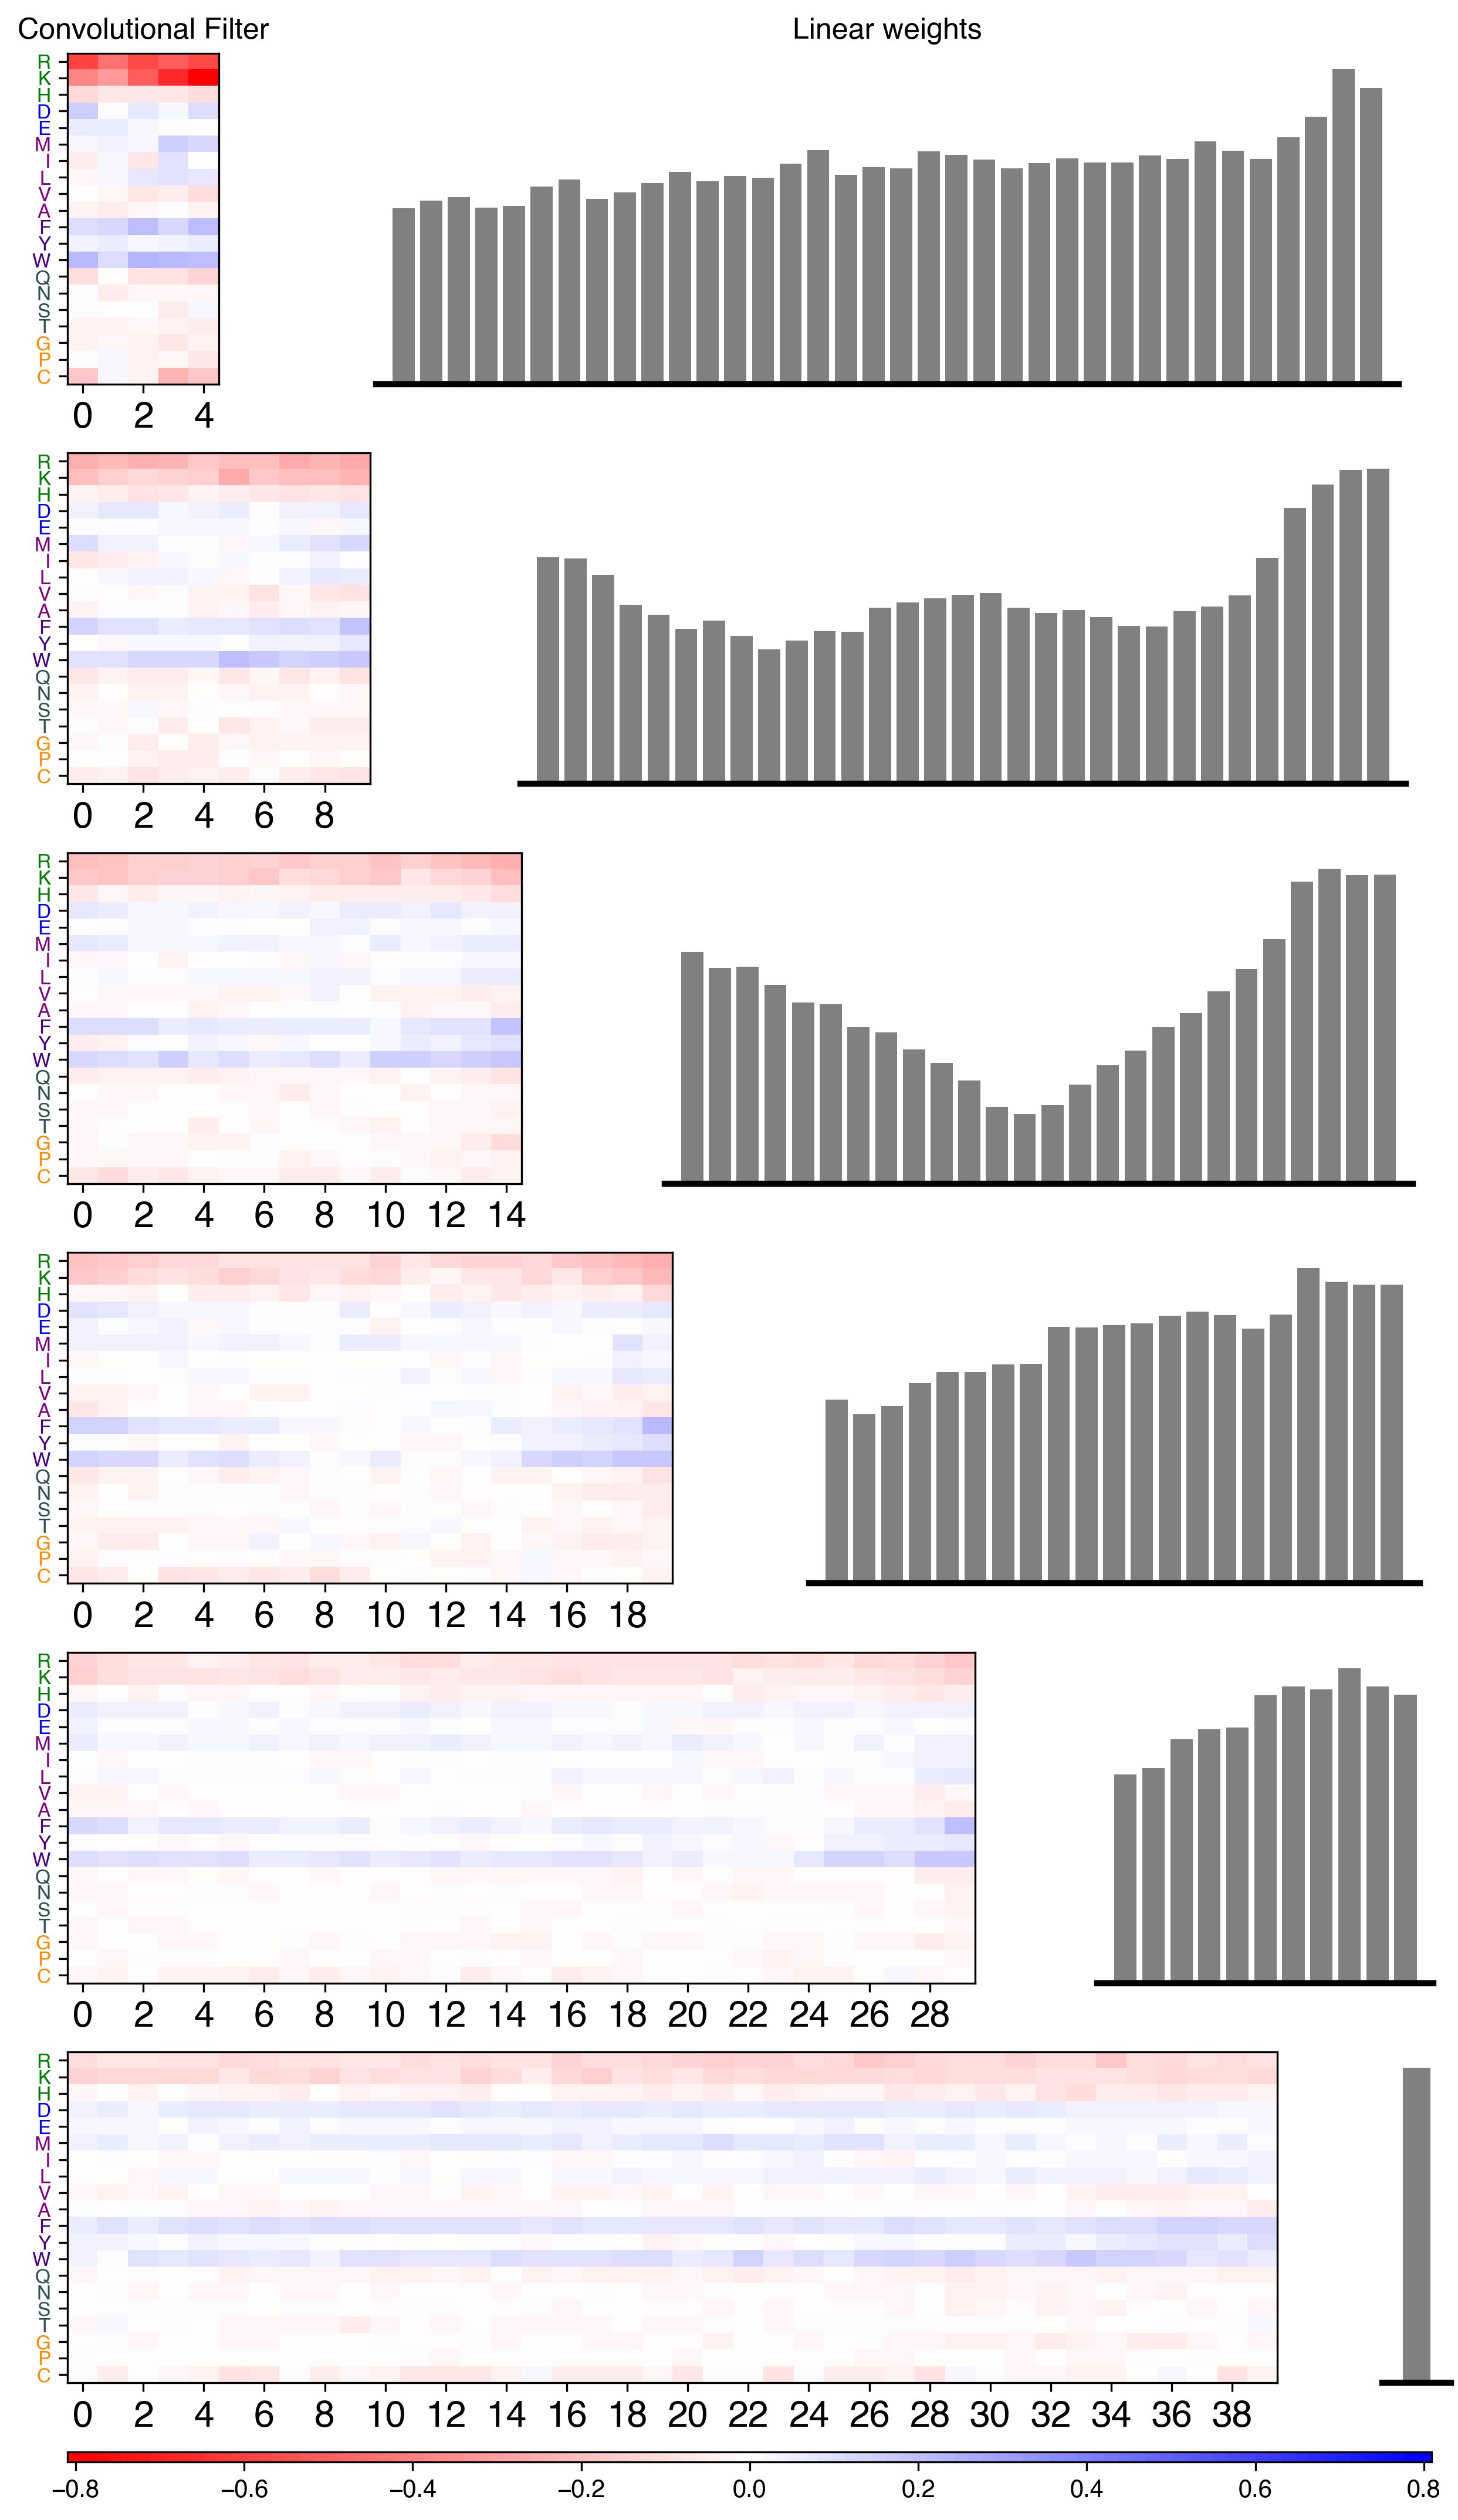

In [268]:
num_rows = 6

conv1_weights_5,  linear_weights_5,  neg_conv1_weights_5,   neg_linear_weights_5 = get_mean_weights(models_5)
conv1_weights_10, linear_weights_10, neg_conv1_weights_10,  neg_linear_weights_10 = get_mean_weights(models_10)
conv1_weights_15, linear_weights_15, neg_conv1_weights_15,  neg_linear_weights_15 = get_mean_weights(models_15)
conv1_weights_20, linear_weights_20, neg_conv1_weights_20,  neg_linear_weights_20 = get_mean_weights(models_20)
conv1_weights_30, linear_weights_30, neg_conv1_weights_30,  neg_linear_weights_30 = get_mean_weights(models_30)
conv1_weights_40, linear_weights_40, neg_conv1_weights_40,  neg_linear_weights_40 = get_mean_weights(models_40)


conv_weights = np.concatenate([conv1_weights_5.flatten(), conv1_weights_10.flatten(), conv1_weights_15.flatten(), conv1_weights_20.flatten(), conv1_weights_30.flatten(), conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 5, conv1_weights_5.T, linear_weights_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 10, conv1_weights_10.T, linear_weights_10, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 15, conv1_weights_15.T, linear_weights_15, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 20, conv1_weights_20.T, linear_weights_20, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 30, conv1_weights_30.T, linear_weights_30, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 40, conv1_weights_40.T, linear_weights_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/simple_act_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


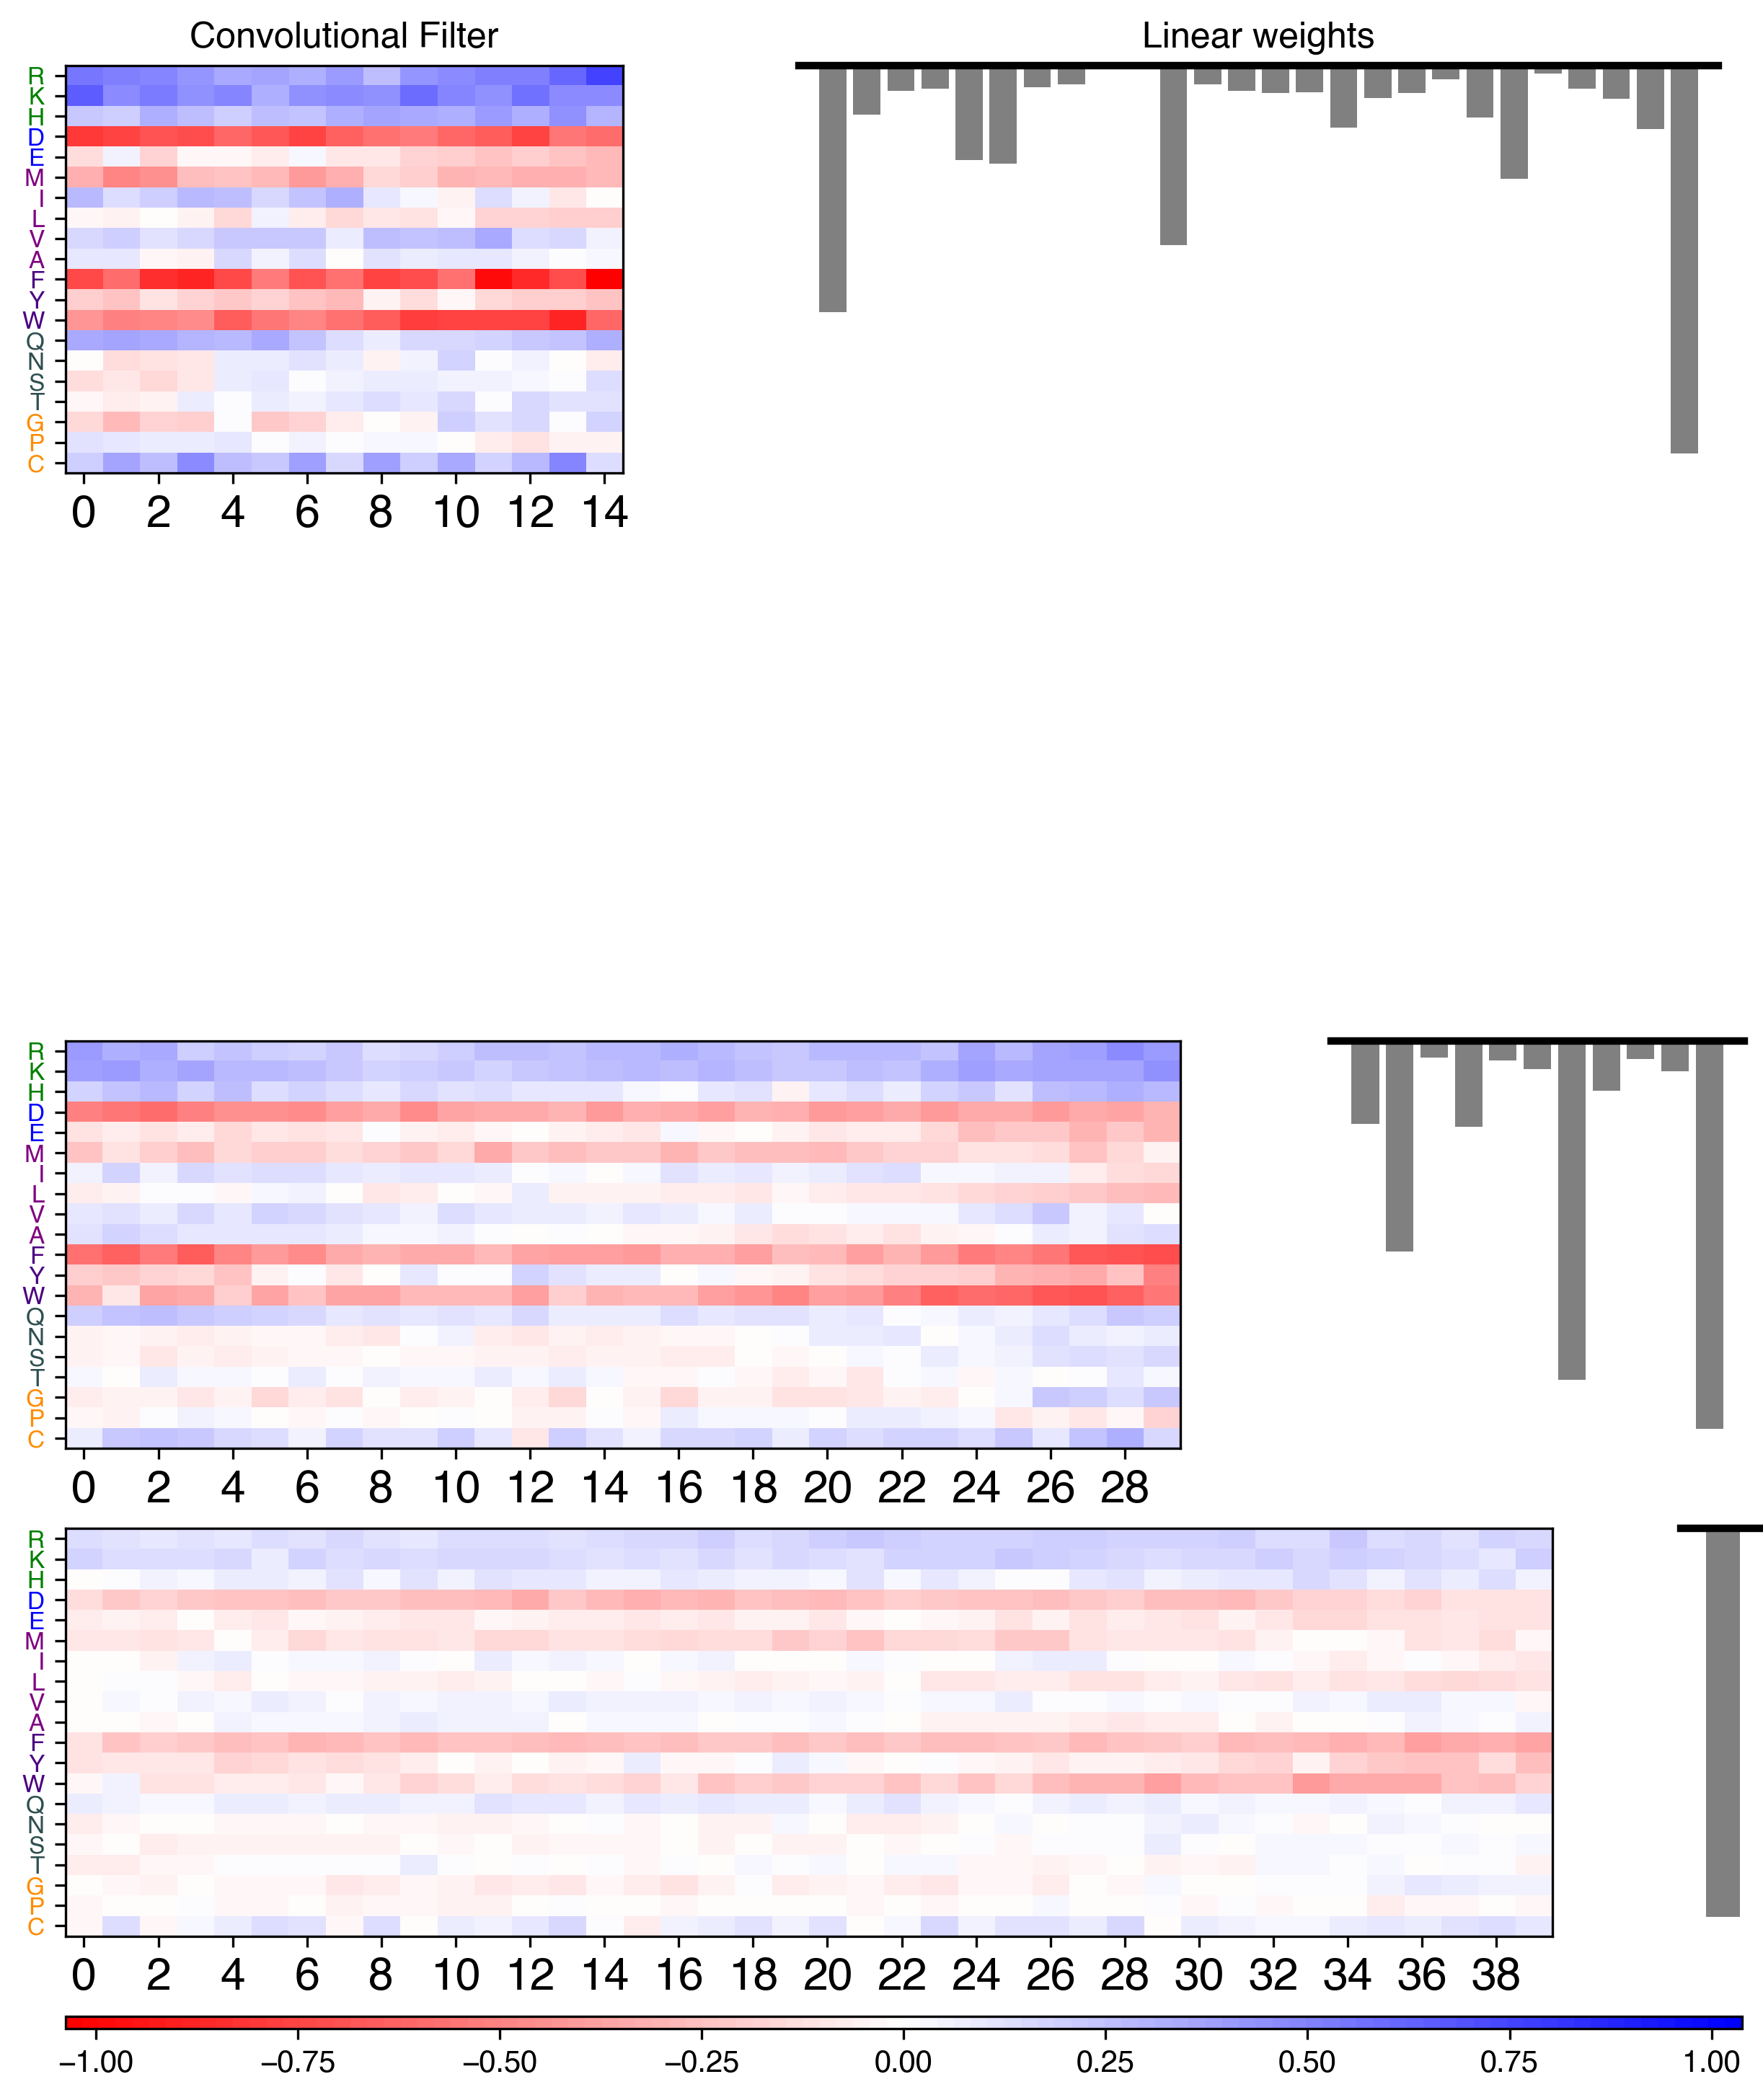

In [275]:
num_rows = 4

conv_weights = np.concatenate([neg_conv1_weights_15.flatten(), neg_conv1_weights_20.flatten(), neg_conv1_weights_30.flatten(), neg_conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 15, neg_conv1_weights_15.T, neg_linear_weights_15, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

# make_row_plot(fig, 20, neg_conv1_weights_20.T, neg_linear_weights_20, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 30, neg_conv1_weights_30.T, neg_linear_weights_30, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 40, neg_conv1_weights_40.T, neg_linear_weights_40, 7, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/simple_act_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# For Simple Abund

In [279]:
size = (1,40,20)
import torch 

def load_model(name, k):
    model = ADModel_abund(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_simple_abund_filtered = data_simple_abund[data_simple_abund[" Rsq_abund_val"] > 0.15]

for index in data_simple_abund_filtered.index:
    K = data_simple_abund_filtered.loc[index, " kernel_size"]
    name = data_simple_abund_filtered.loc[index, "model_name"]
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K))
    elif K == 10:
        models_10.append(load_model(name, K))
    elif K == 15:
        models_15.append(load_model(name, K))
    elif K == 20:
        models_20.append(load_model(name, K))
    elif K == 30:
        models_30.append(load_model(name, K))
    elif K == 40:
        models_40.append(load_model(name, K))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


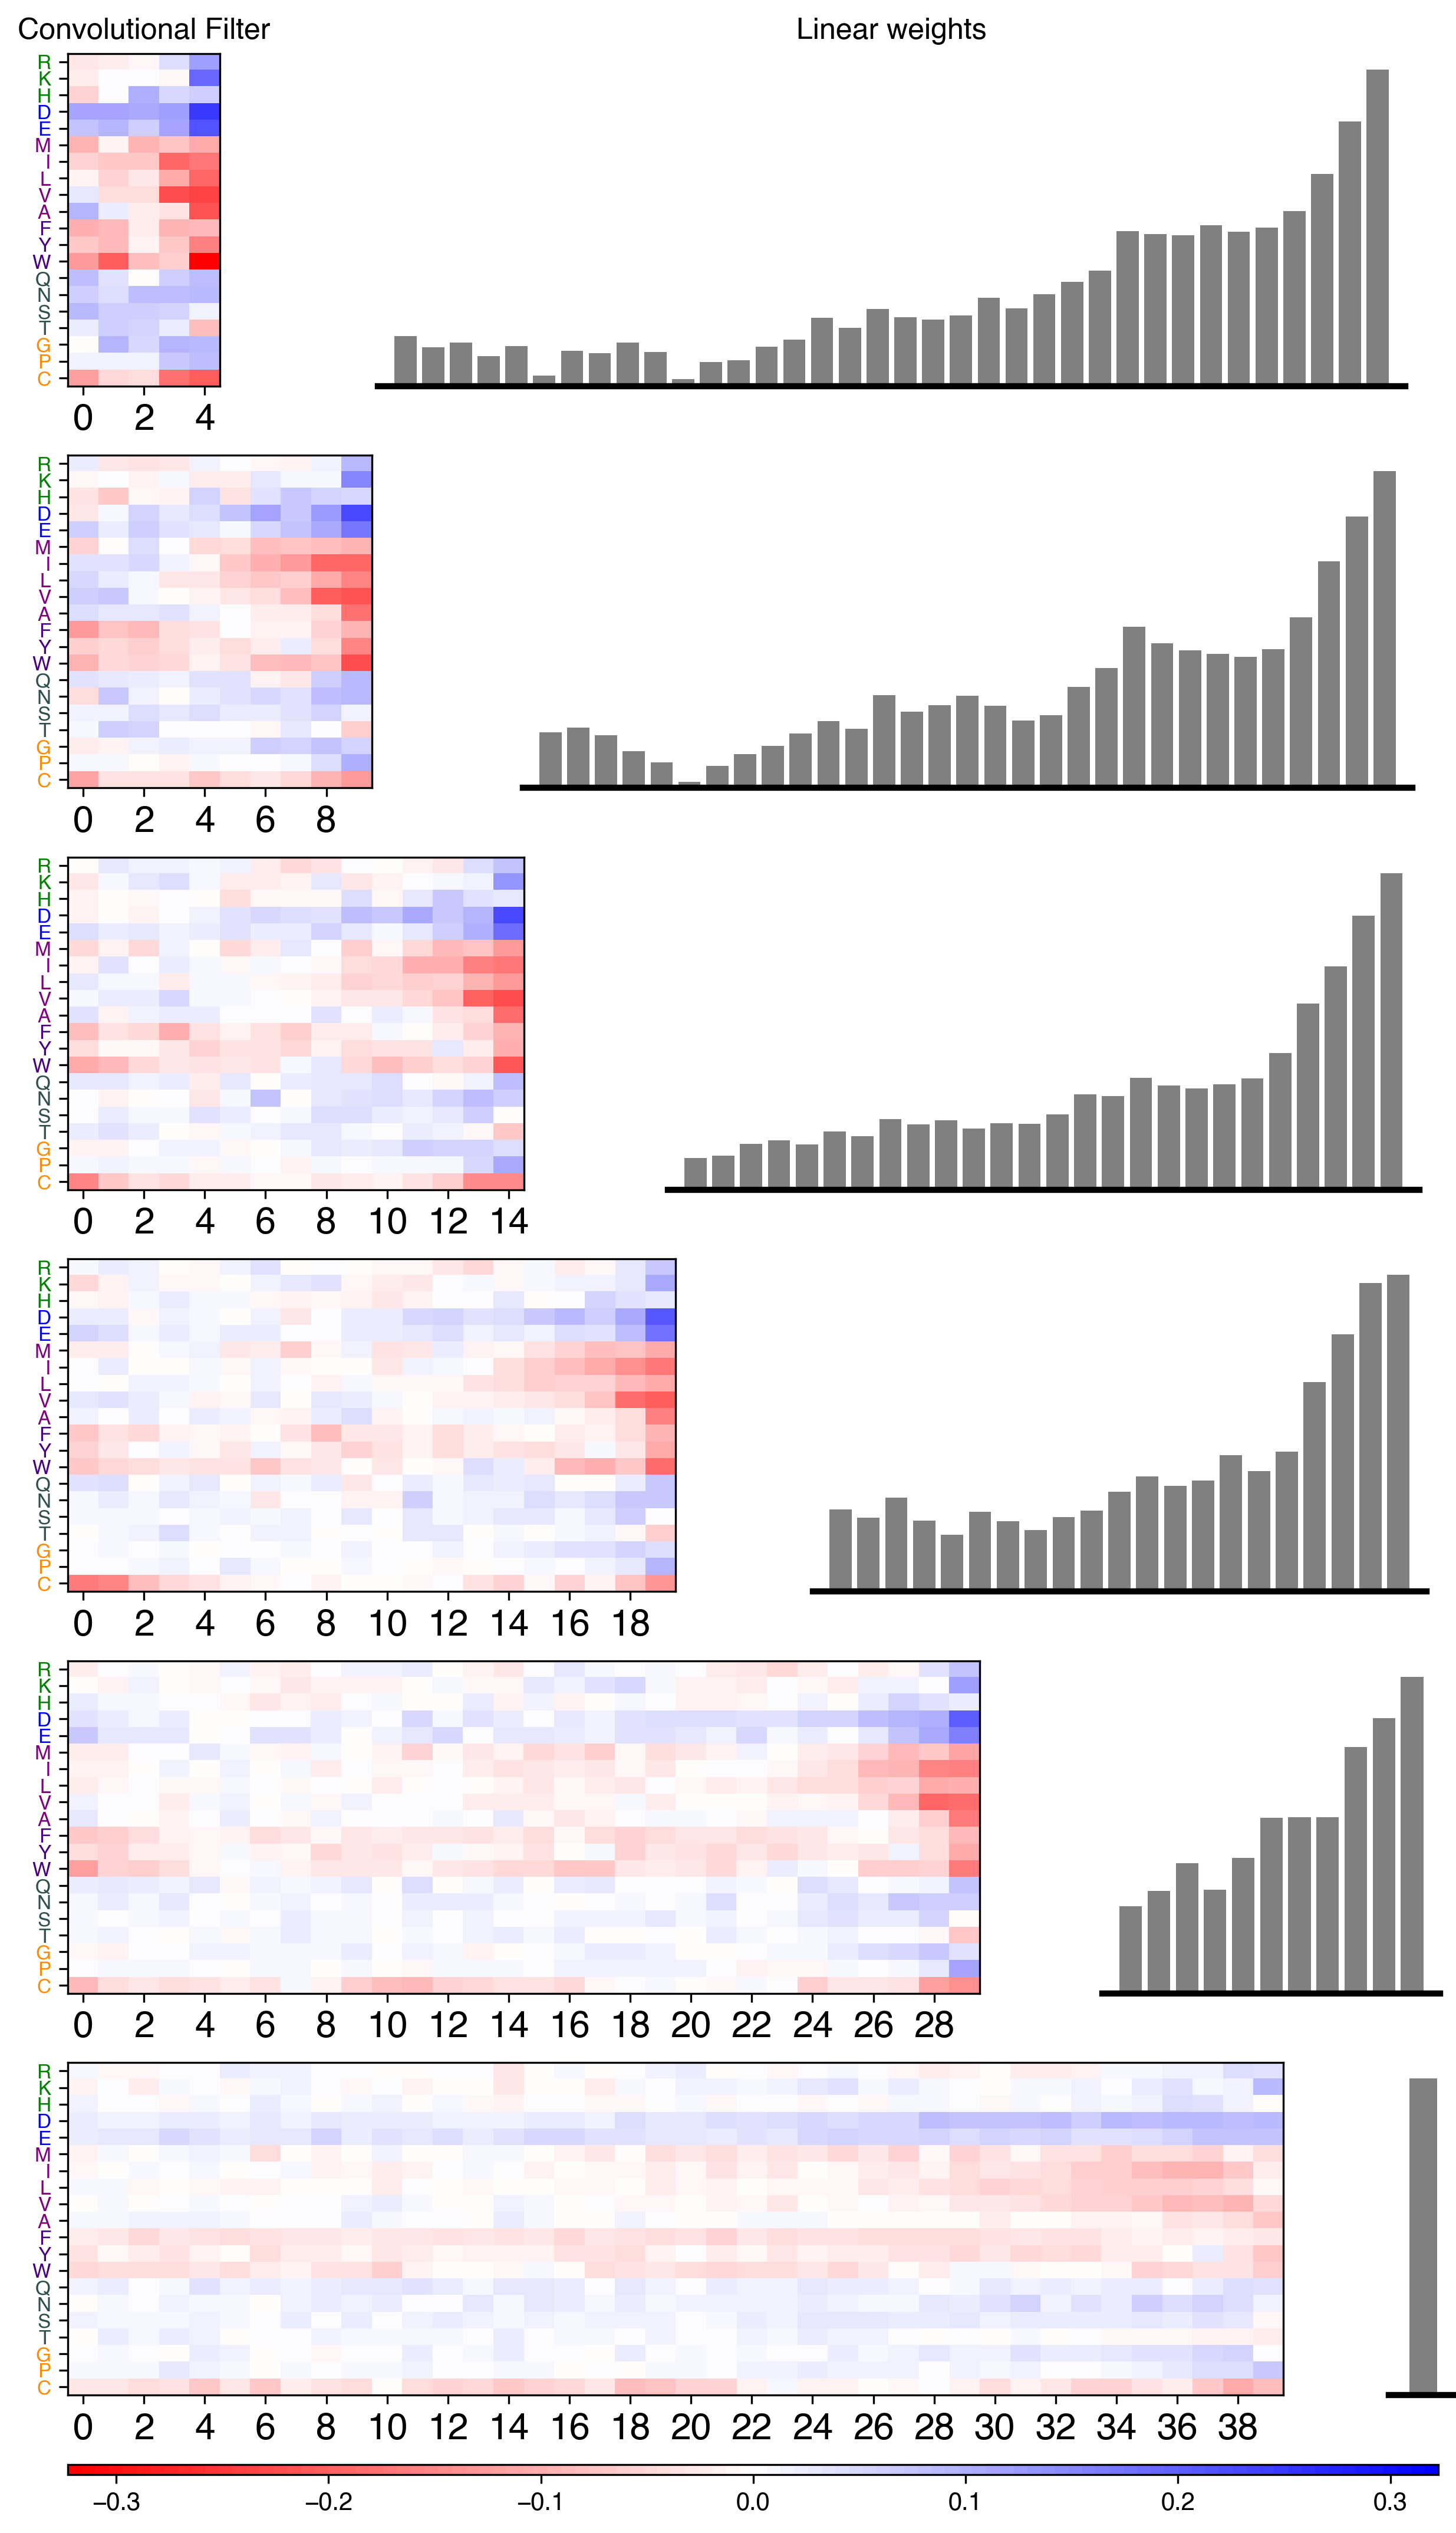

In [282]:
num_rows = 6

conv1_weights_5,  linear_weights_5,  neg_conv1_weights_5,   neg_linear_weights_5 = get_mean_weights(models_5)
conv1_weights_10, linear_weights_10, neg_conv1_weights_10,  neg_linear_weights_10 = get_mean_weights(models_10)
conv1_weights_15, linear_weights_15, neg_conv1_weights_15,  neg_linear_weights_15 = get_mean_weights(models_15)
conv1_weights_20, linear_weights_20, neg_conv1_weights_20,  neg_linear_weights_20 = get_mean_weights(models_20)
conv1_weights_30, linear_weights_30, neg_conv1_weights_30,  neg_linear_weights_30 = get_mean_weights(models_30)
conv1_weights_40, linear_weights_40, neg_conv1_weights_40,  neg_linear_weights_40 = get_mean_weights(models_40)


conv_weights = np.concatenate([conv1_weights_5.flatten(), conv1_weights_10.flatten(), conv1_weights_15.flatten(), conv1_weights_20.flatten(), conv1_weights_30.flatten(), conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 5, conv1_weights_5.T, linear_weights_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 10, conv1_weights_10.T, linear_weights_10, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 15, conv1_weights_15.T, linear_weights_15, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 20, conv1_weights_20.T, linear_weights_20, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 30, conv1_weights_30.T, linear_weights_30, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 40, conv1_weights_40.T, linear_weights_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/simple_abund_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


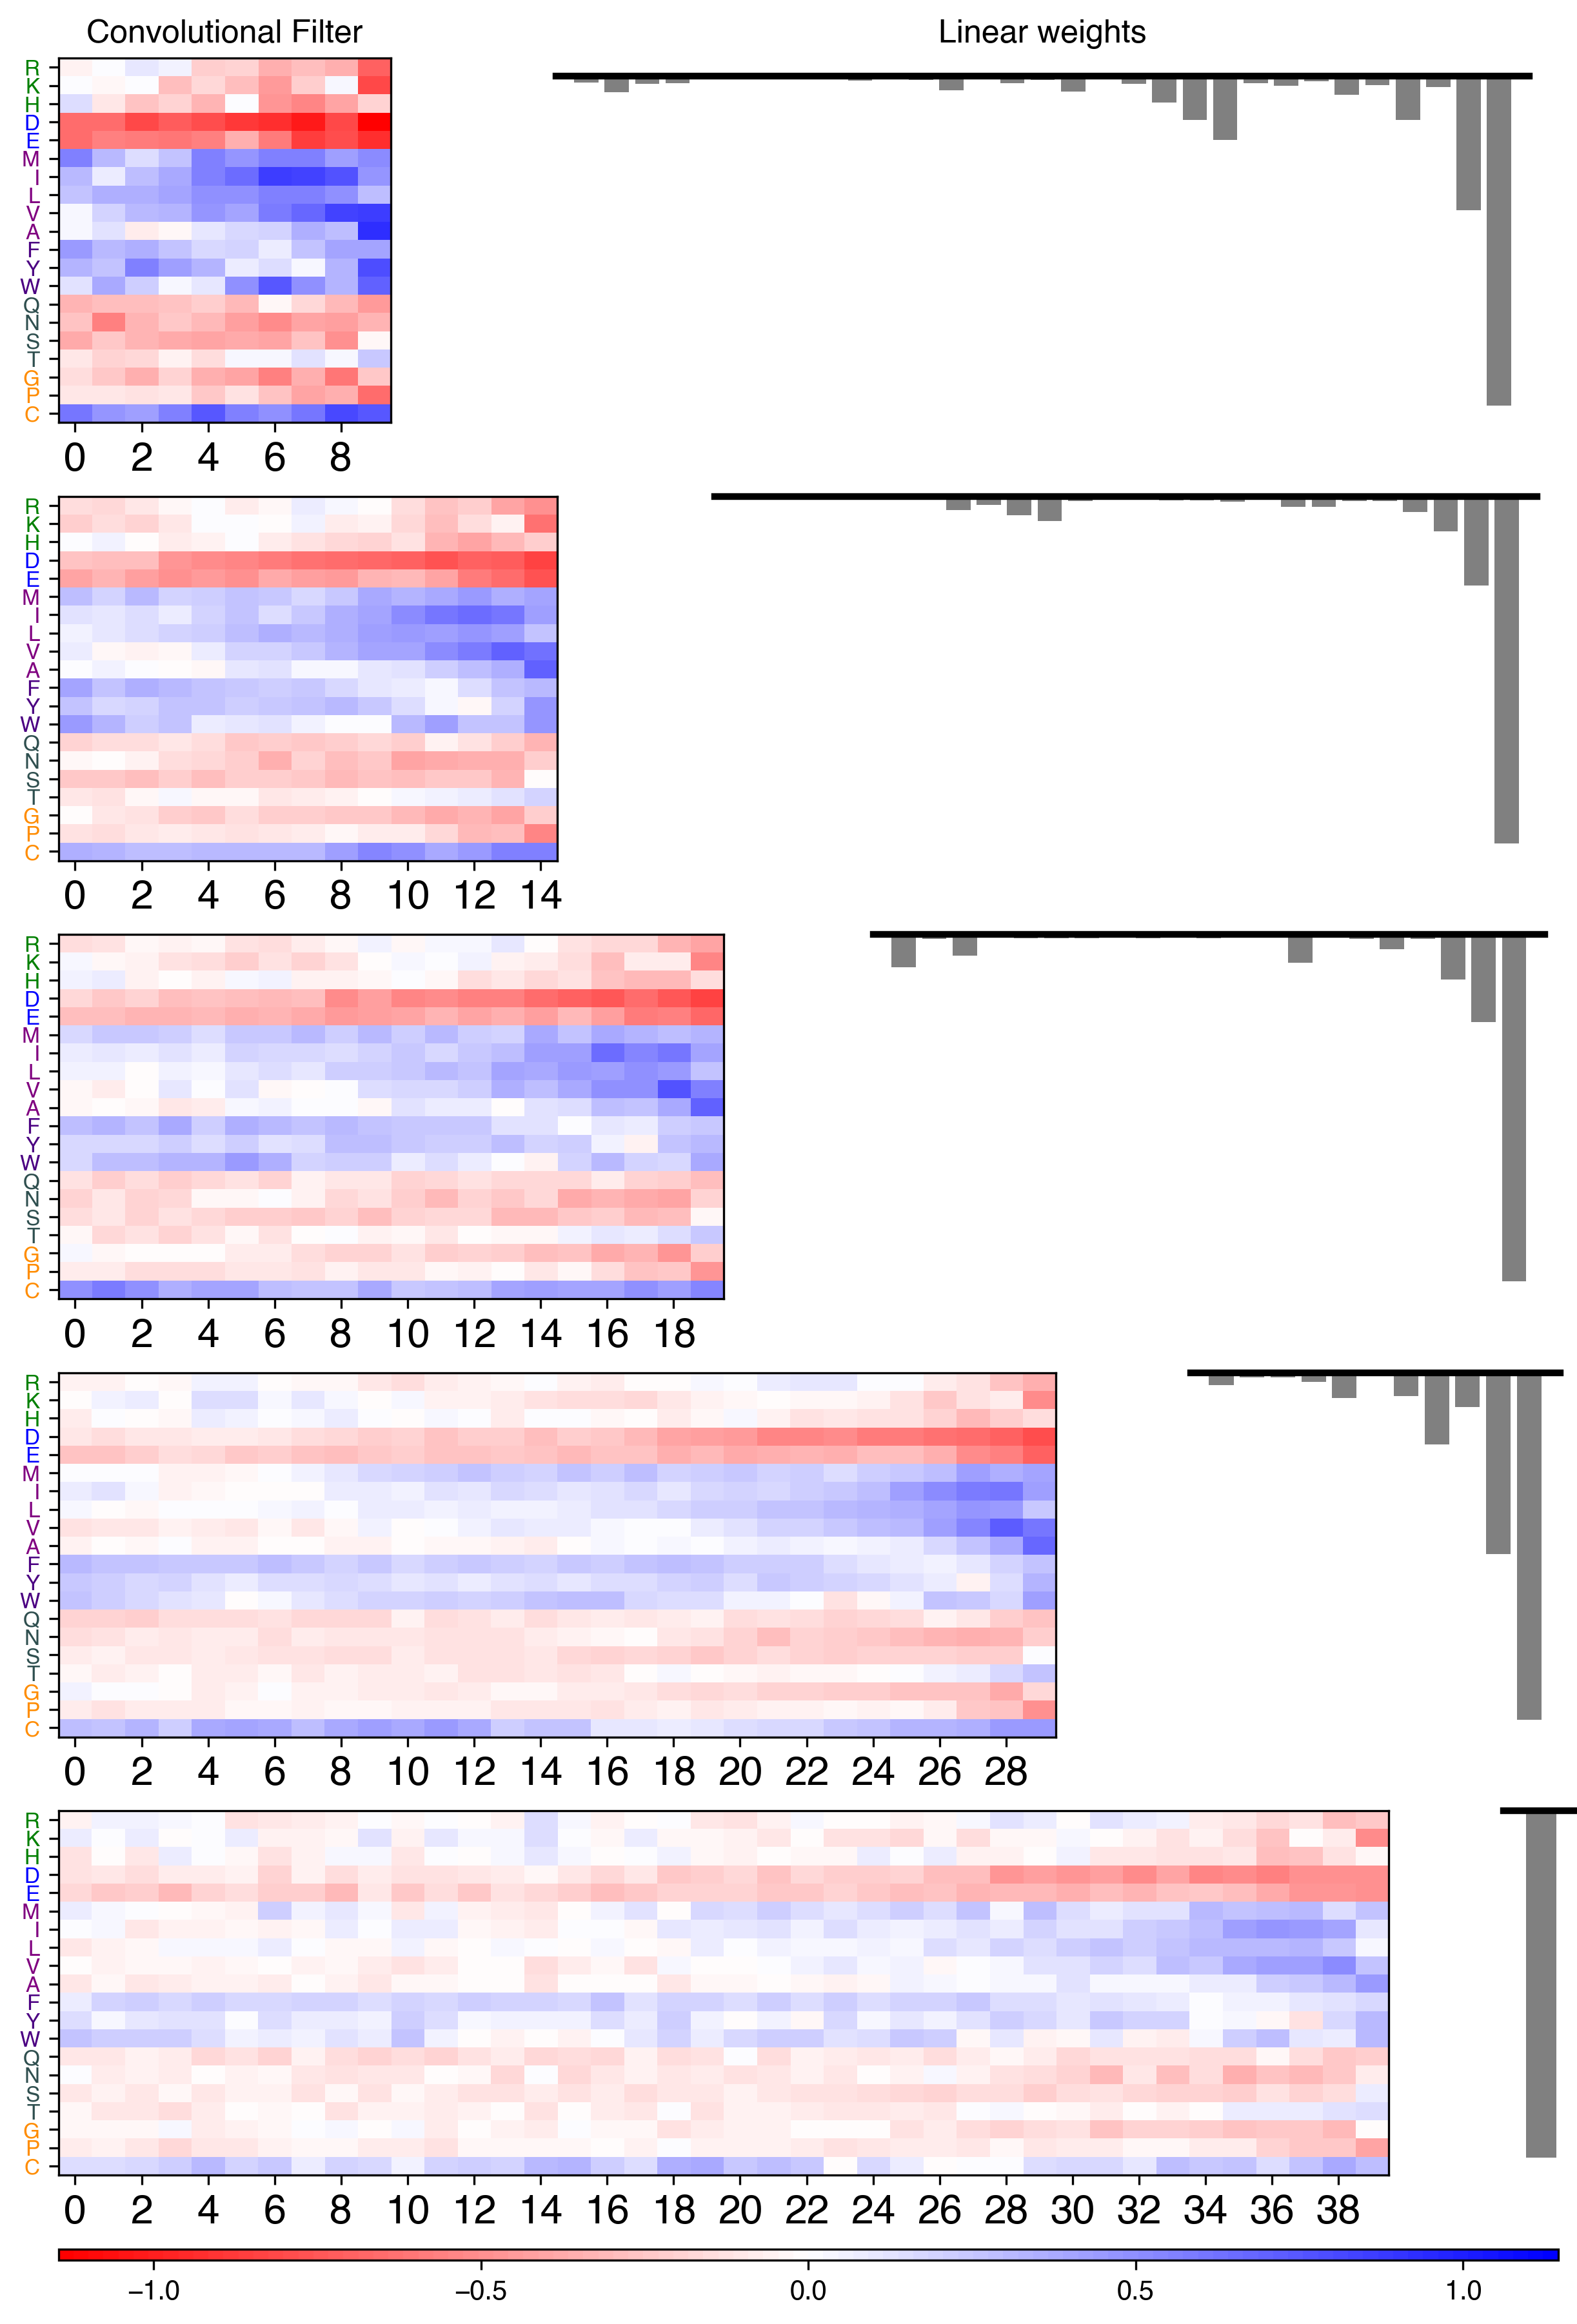

In [283]:
num_rows = 5

conv_weights = np.concatenate([neg_conv1_weights_10.flatten(), neg_conv1_weights_15.flatten(), neg_conv1_weights_20.flatten(), neg_conv1_weights_30.flatten(), neg_conv1_weights_40.flatten()])

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 10, neg_conv1_weights_10.T, neg_linear_weights_10, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 15, neg_conv1_weights_15.T, neg_linear_weights_15, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 20, neg_conv1_weights_20.T, neg_linear_weights_20, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 30, neg_conv1_weights_30.T, neg_linear_weights_30, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 40, neg_conv1_weights_40.T, neg_linear_weights_40, 9, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/simple_abund_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# Best perfoming individual models - Abund

In [114]:
best_abund = data_simple_abund.sort_values(" Rsq_abund_val", ascending=False).drop_duplicates(" kernel_size", keep="first")

In [115]:
size = (1,40,20)
import torch 

def load_model(name, k):
    model = ADModel_abund(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_abund.index:
    K = best_abund.loc[index, " kernel_size"]
    name = best_abund.loc[index, "model_name"]
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        model_5 = load_model(name, K)
    elif K == 10:
        model_10 = load_model(name, K)
    elif K == 15:
        model_15 = load_model(name, K)
    elif K == 20:
        model_20 = load_model(name, K)
    elif K == 30:
        model_30 = load_model(name, K)
    elif K == 40:
        model_40 = load_model(name, K)


In [385]:
def make_row_plot_best(fig, kernel_size, model, row, lim, height_ratios, num_rows):

    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 


    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)

    ax2.spines['bottom'].set_bounds(min(model_xvals1) - 1, max(model_xvals1) + 1)
    
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

# Weights preparation
def get_conv_weights(model, layer): 
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals

In [287]:
# Red often represents negative charges
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


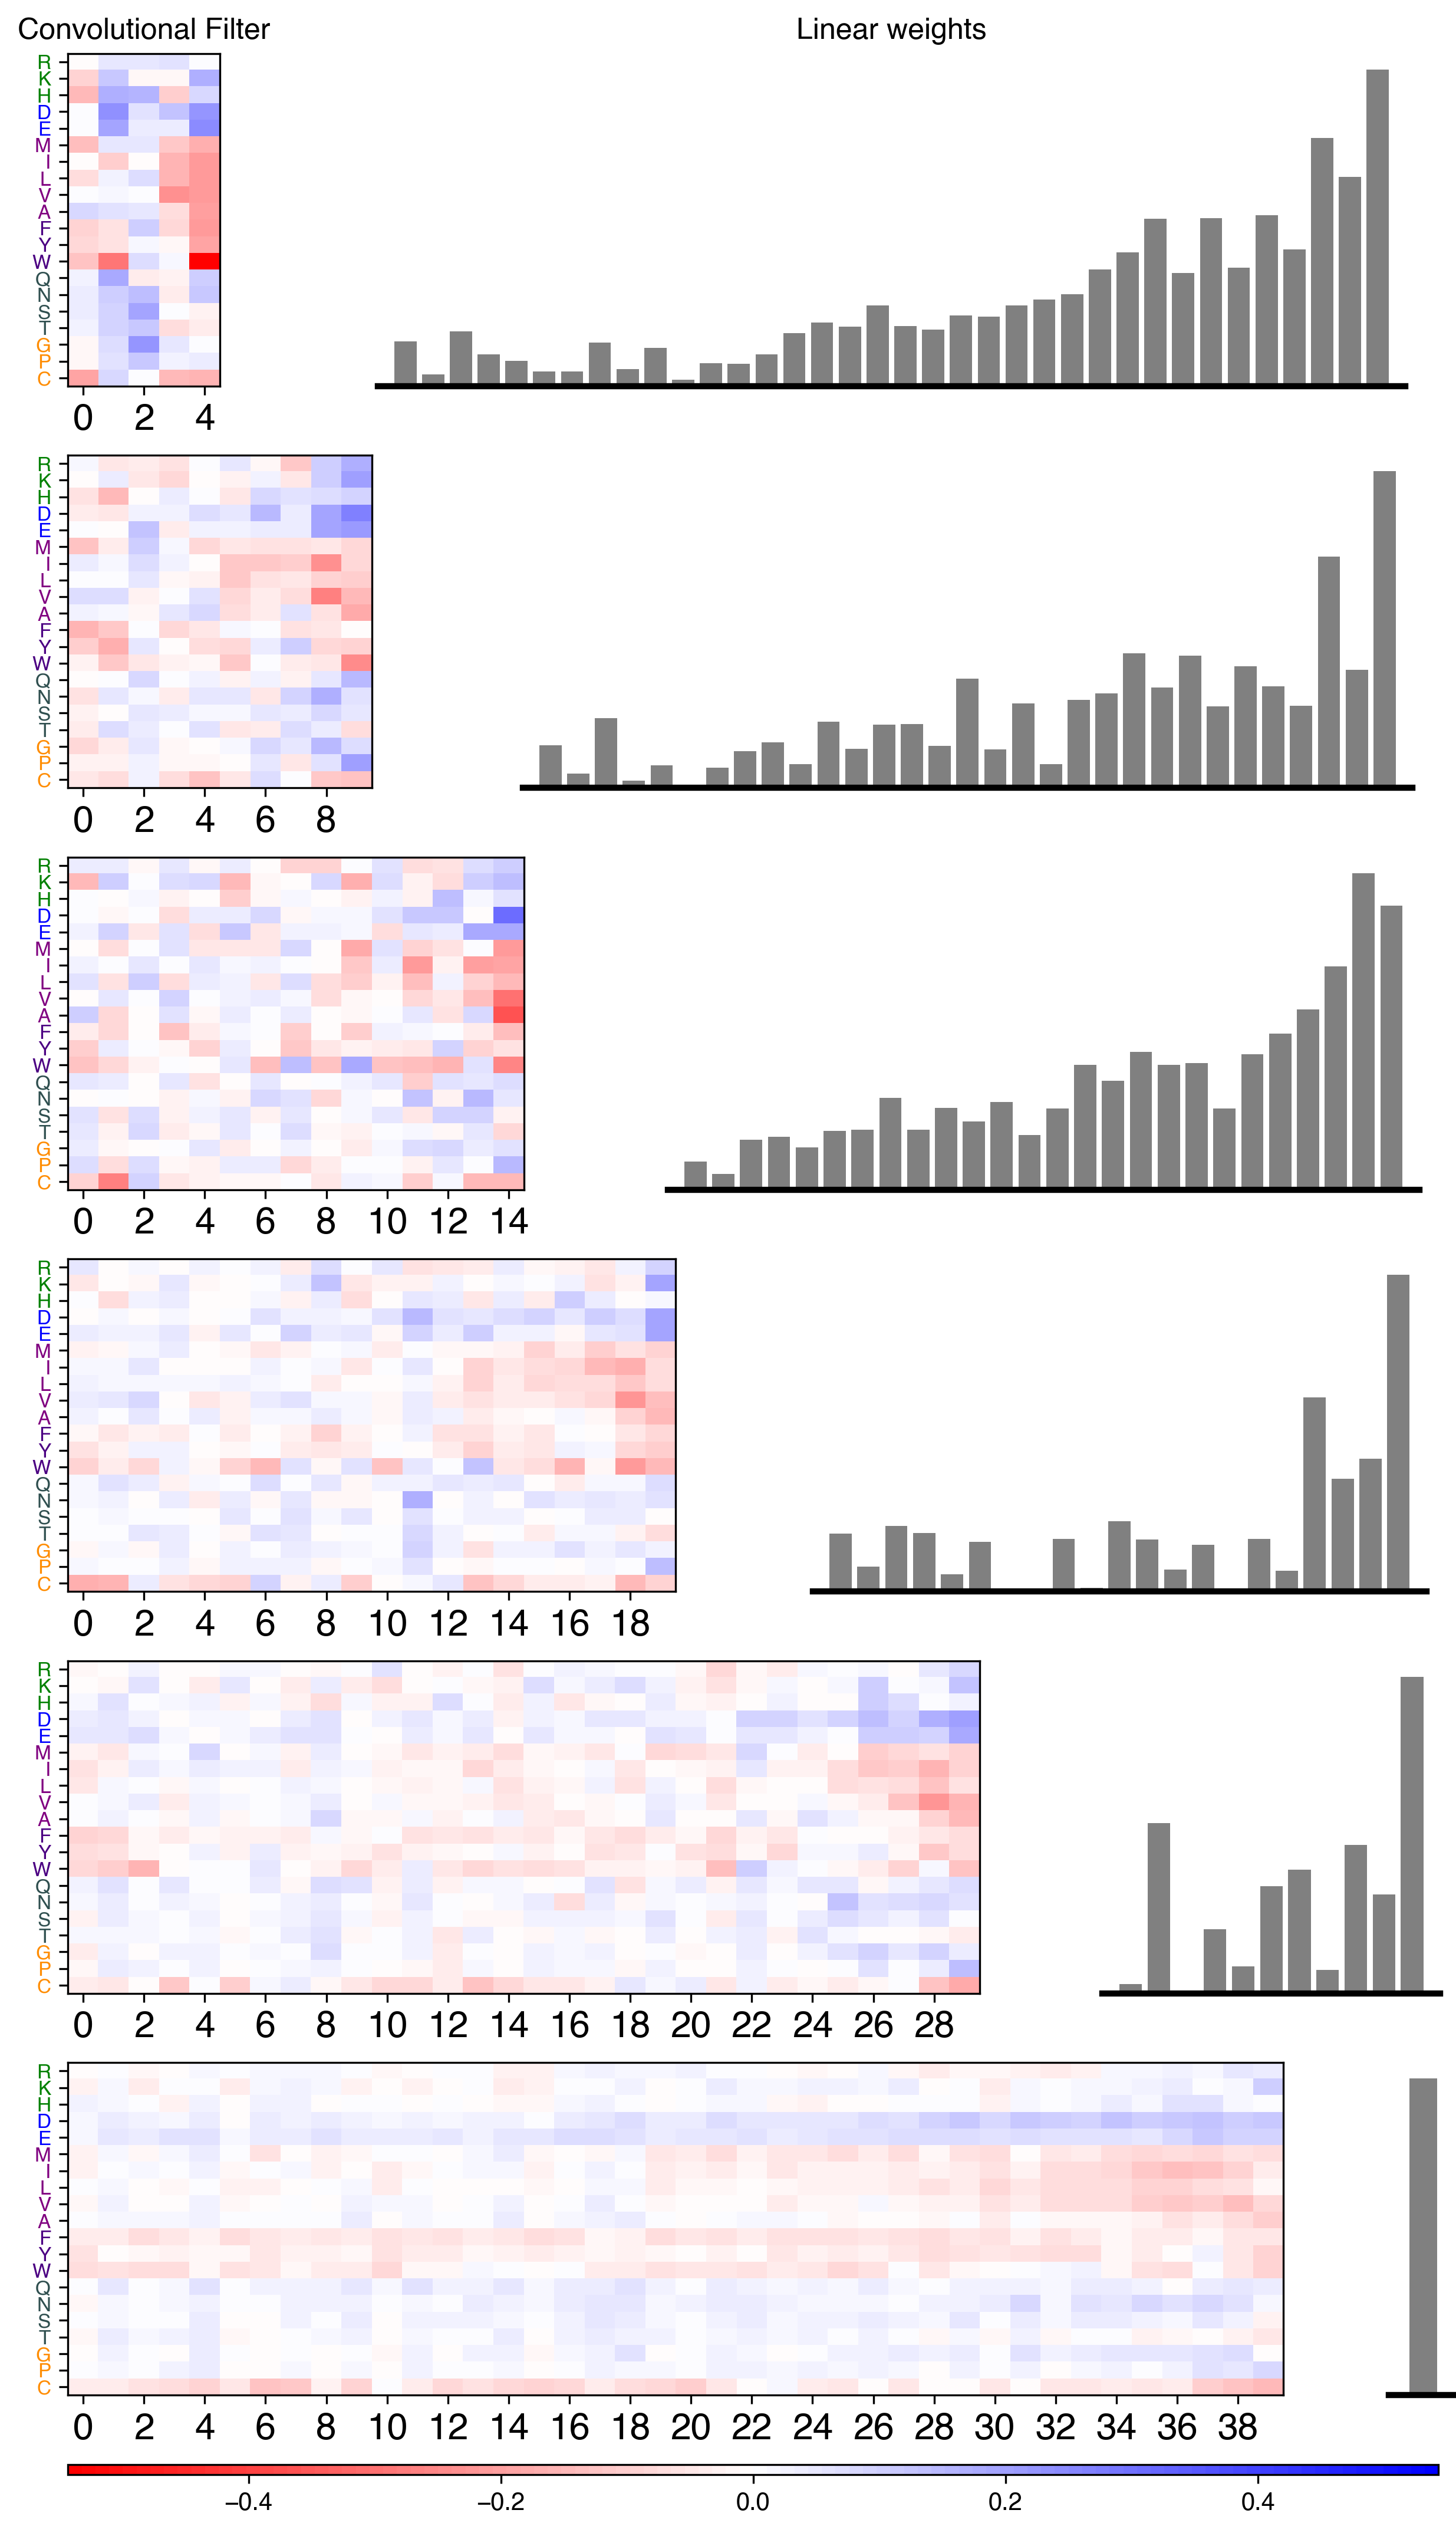

In [ ]:
num_rows = 6
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot_best(fig, 5, model_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

make_row_plot_best(fig, 10, model_10, 3, lim, height_ratios, num_rows)
make_row_plot_best(fig, 15, model_15, 5, lim, height_ratios, num_rows)
make_row_plot_best(fig, 20, model_20, 7, lim, height_ratios, num_rows)
make_row_plot_best(fig, 30, model_30, 9, lim, height_ratios, num_rows)
make_row_plot_best(fig, 40, model_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/simple_abund_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Best models, Activity

In [288]:
best_act = data_simple_act.sort_values("Rs1_act_val", ascending=False).drop_duplicates(" kernel_size", keep="first")

size = (1,40,20)
import torch 

def load_model(name, k):
    model = ADModel_act(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_act.index:
    K = best_act.loc[index, " kernel_size"]
    name = best_act.loc[index, "model_name"]
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        model_5 = load_model(name, K)
    elif K == 10:
        model_10 = load_model(name, K)
    elif K == 15:
        model_15 = load_model(name, K)
    elif K == 20:
        model_20 = load_model(name, K)
    elif K == 30:
        model_30 = load_model(name, K)
    elif K == 40:
        model_40 = load_model(name, K)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


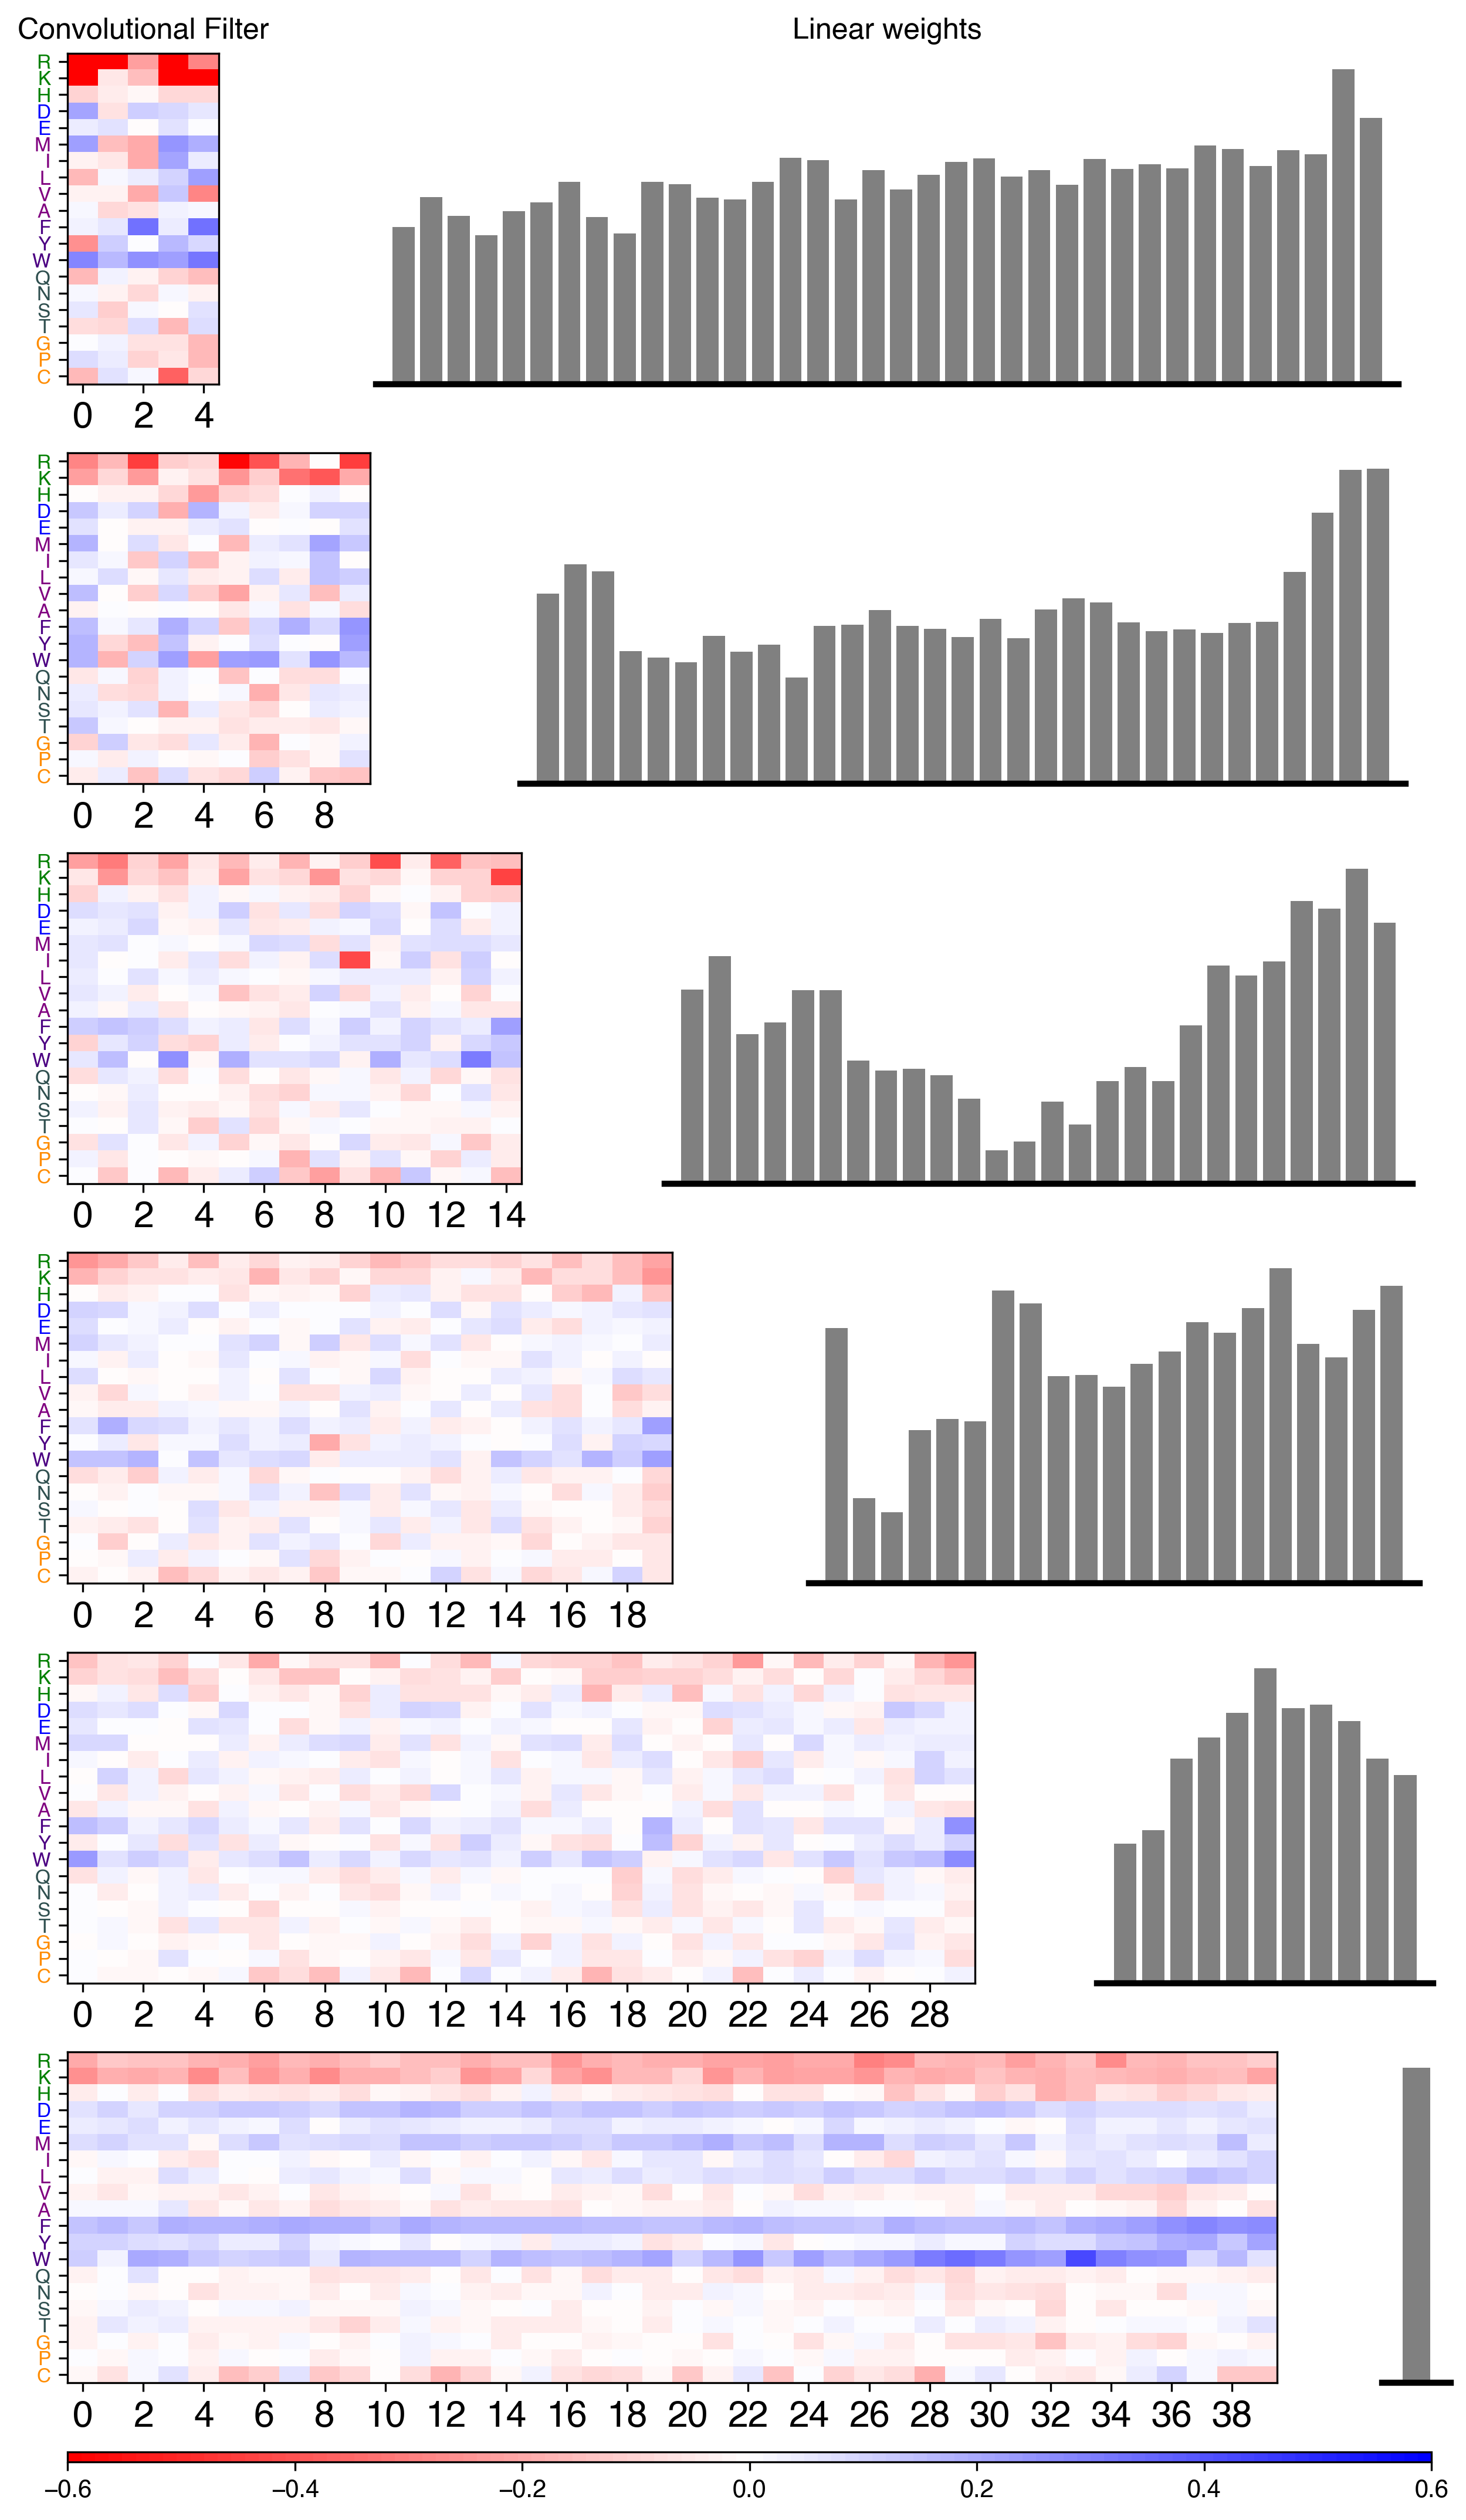

In [ ]:
num_rows = 6
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

# lim = max([abs(w) for w in conv_weights])
lim = 0.6

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot_best(fig, 5, model_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

make_row_plot_best(fig, 10, model_10, 3, lim, height_ratios, num_rows)
make_row_plot_best(fig, 15, model_15, 5, lim, height_ratios, num_rows)
make_row_plot_best(fig, 20, model_20, 7, lim, height_ratios, num_rows)
make_row_plot_best(fig, 30, model_30, 9, lim, height_ratios, num_rows)
make_row_plot_best(fig, 40, model_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/simple_best_supp_act_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Best performing model - two state

In [328]:
best_two_state = data_two_state.sort_values("Rs1_act_val", ascending=False).drop_duplicates(" kernel_size", keep="first")

size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_two_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_two_state.index:
    K = best_two_state.loc[index, " kernel_size"]
    name = best_two_state.loc[index, "model_name"]
    ak = int(data_two_state.loc[index, "abund_kernel_size"])
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        model_5 = load_model(name, K, ak)
    elif K == 10:
        model_10 = load_model(name, K, ak)
    elif K == 15:
        model_15 = load_model(name, K, ak)
    elif K == 20:
        model_20 = load_model(name, K, ak)
    elif K == 30:
        model_30 = load_model(name, K, ak)
    elif K == 40:
        model_40 = load_model(name, K, ak)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


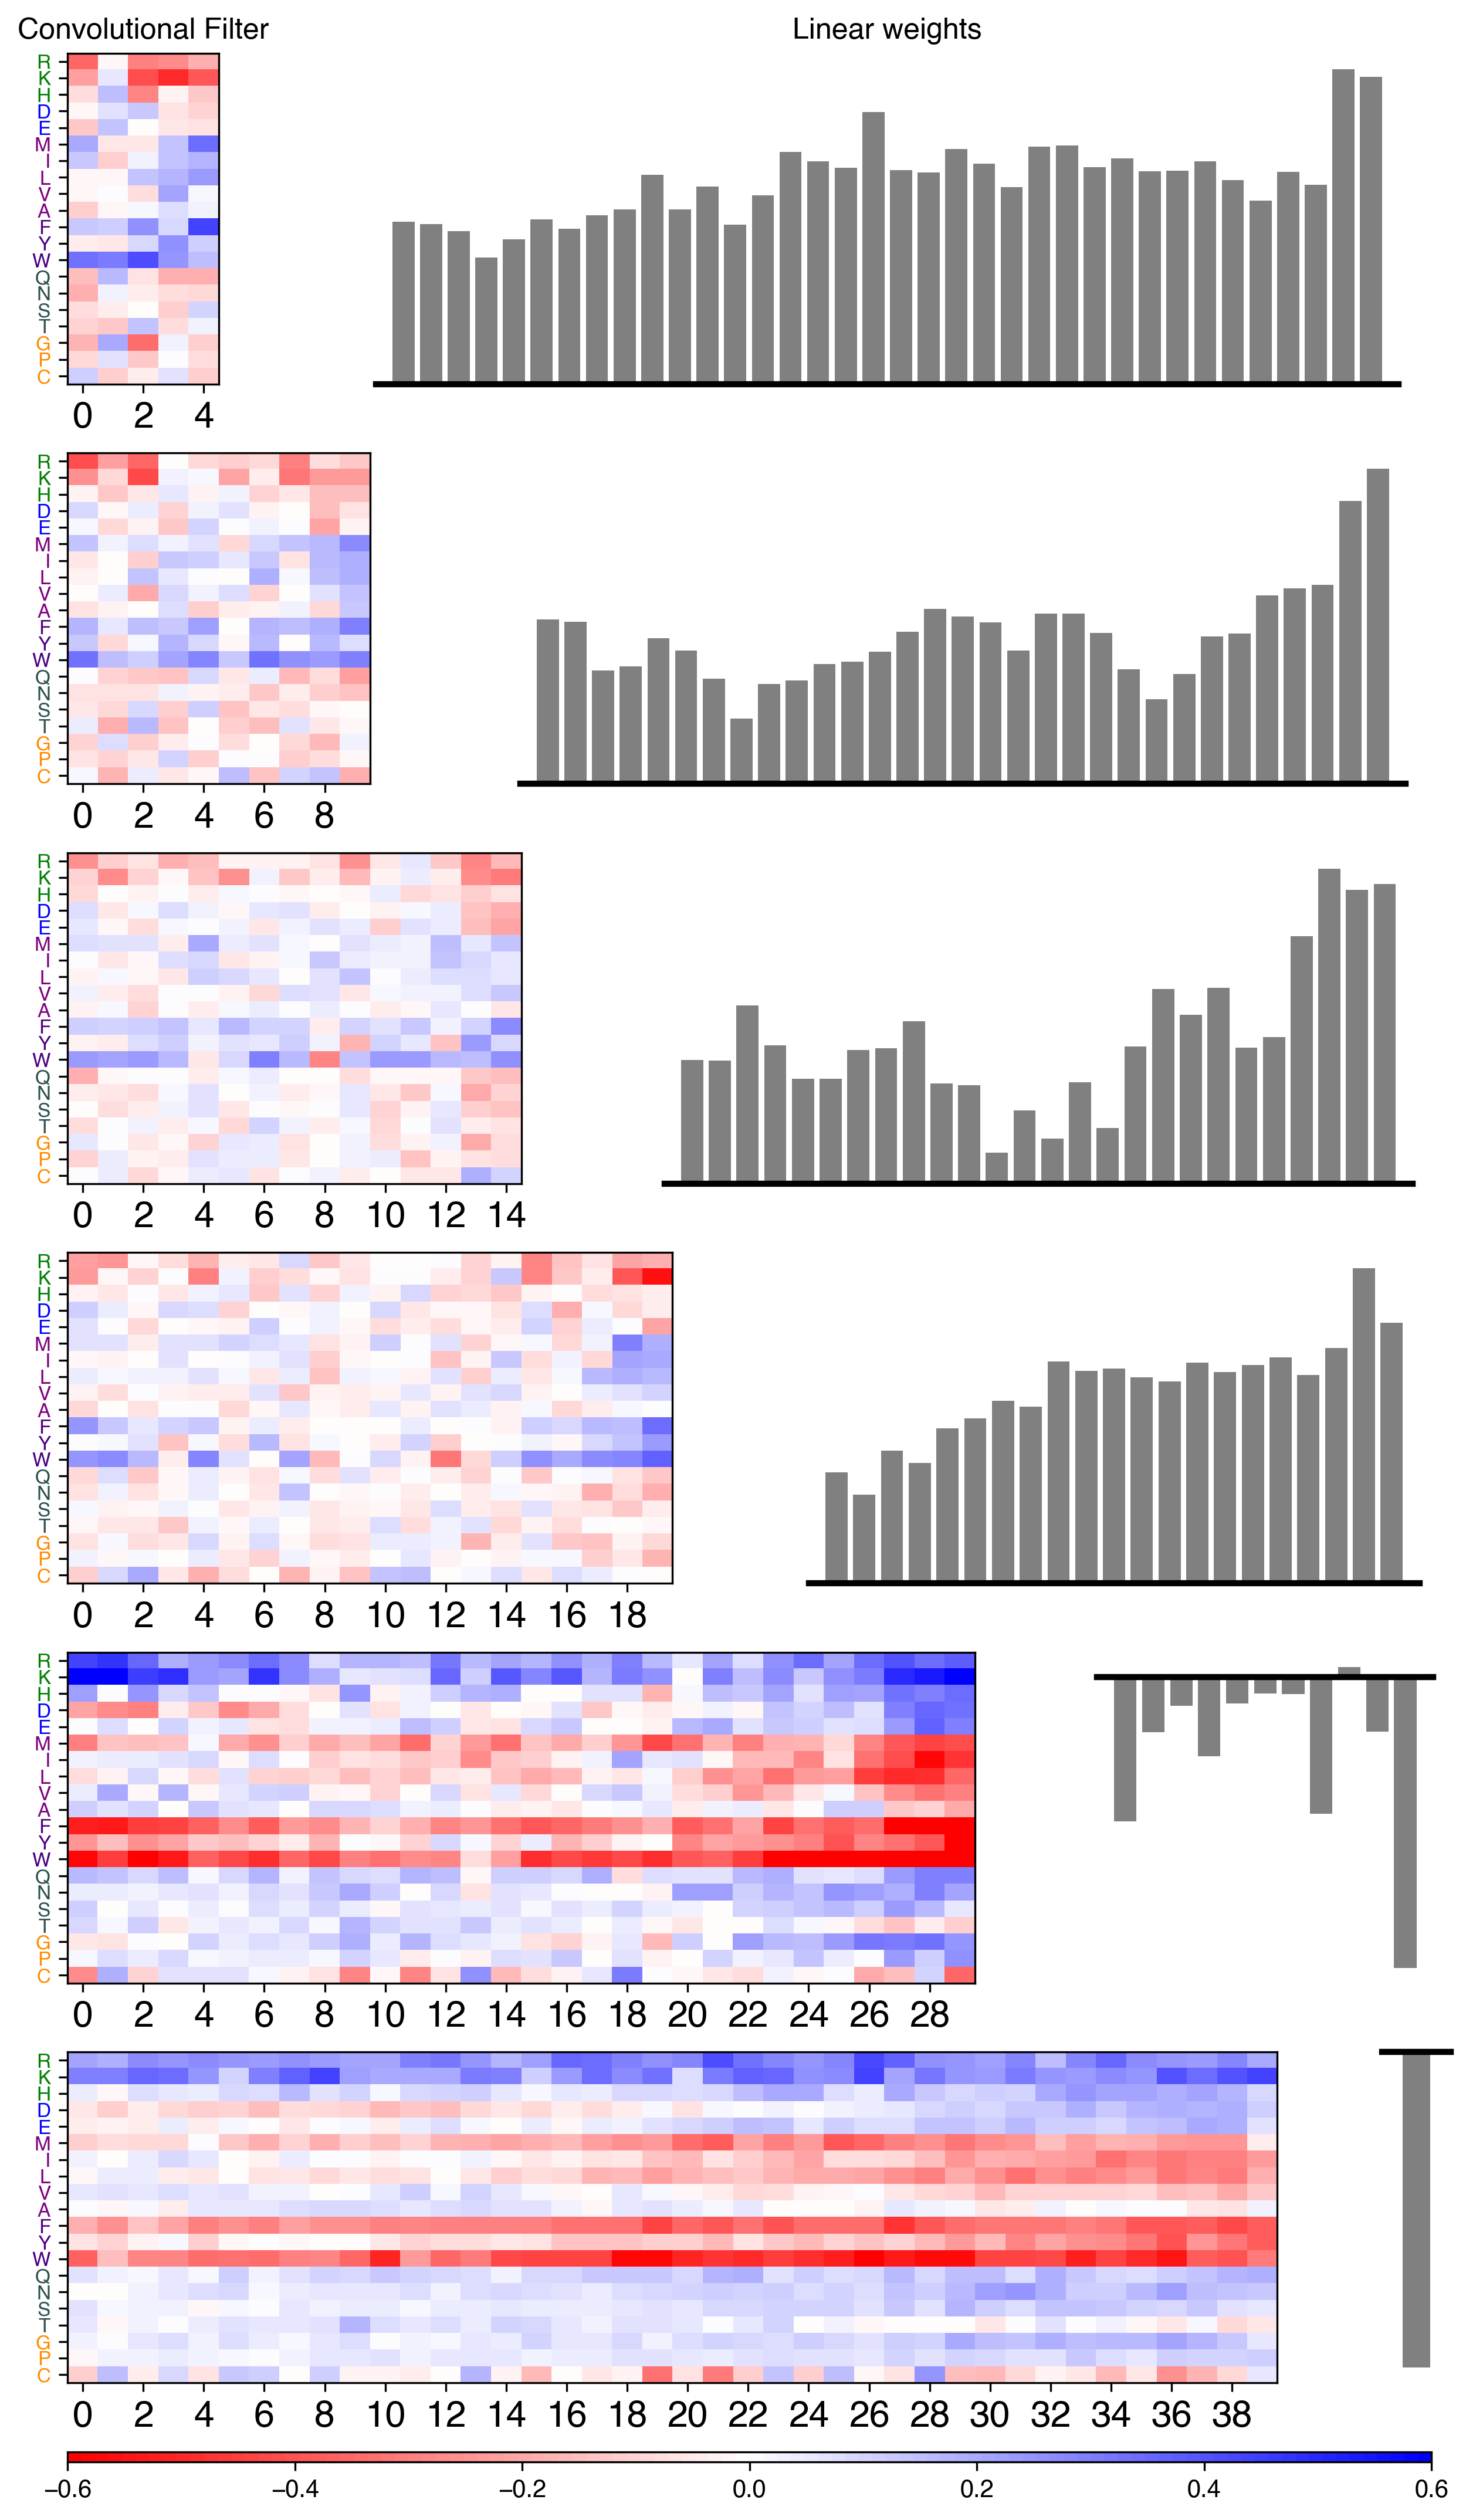

In [ ]:
num_rows = 6
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

# lim = max([abs(w) for w in conv_weights])
lim = 0.6

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot_best(fig, 5, model_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

make_row_plot_best(fig, 10, model_10, 3, lim, height_ratios, num_rows)
make_row_plot_best(fig, 15, model_15, 5, lim, height_ratios, num_rows)
make_row_plot_best(fig, 20, model_20, 7, lim, height_ratios, num_rows)
make_row_plot_best(fig, 30, model_30, 9, lim, height_ratios, num_rows)
make_row_plot_best(fig, 40, model_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/two_state_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Best models - three state

In [342]:
best_three_state = data_three_state[data_three_state[' Rsq_abund_val'] > 0.2].sort_values("Rs1_act_val", ascending=False).drop_duplicates(" kernel_size", keep="first")

size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_three_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_three_state.index:
    K = best_three_state.loc[index, " kernel_size"]
    name = best_three_state.loc[index, "model_name"]
    ak = int(best_three_state.loc[index, "abund_kernel_size"])

    if K == 5:
        model_5 = load_model(name, K, ak)
    elif K == 10:
        model_10 = load_model(name, K, ak)
    elif K == 15:
        model_15 = load_model(name, K, ak)
    elif K == 20:
        model_20 = load_model(name, K, ak)
    elif K == 30:
        model_30 = load_model(name, K, ak)
    elif K == 40:
        model_40 = load_model(name, K, ak)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


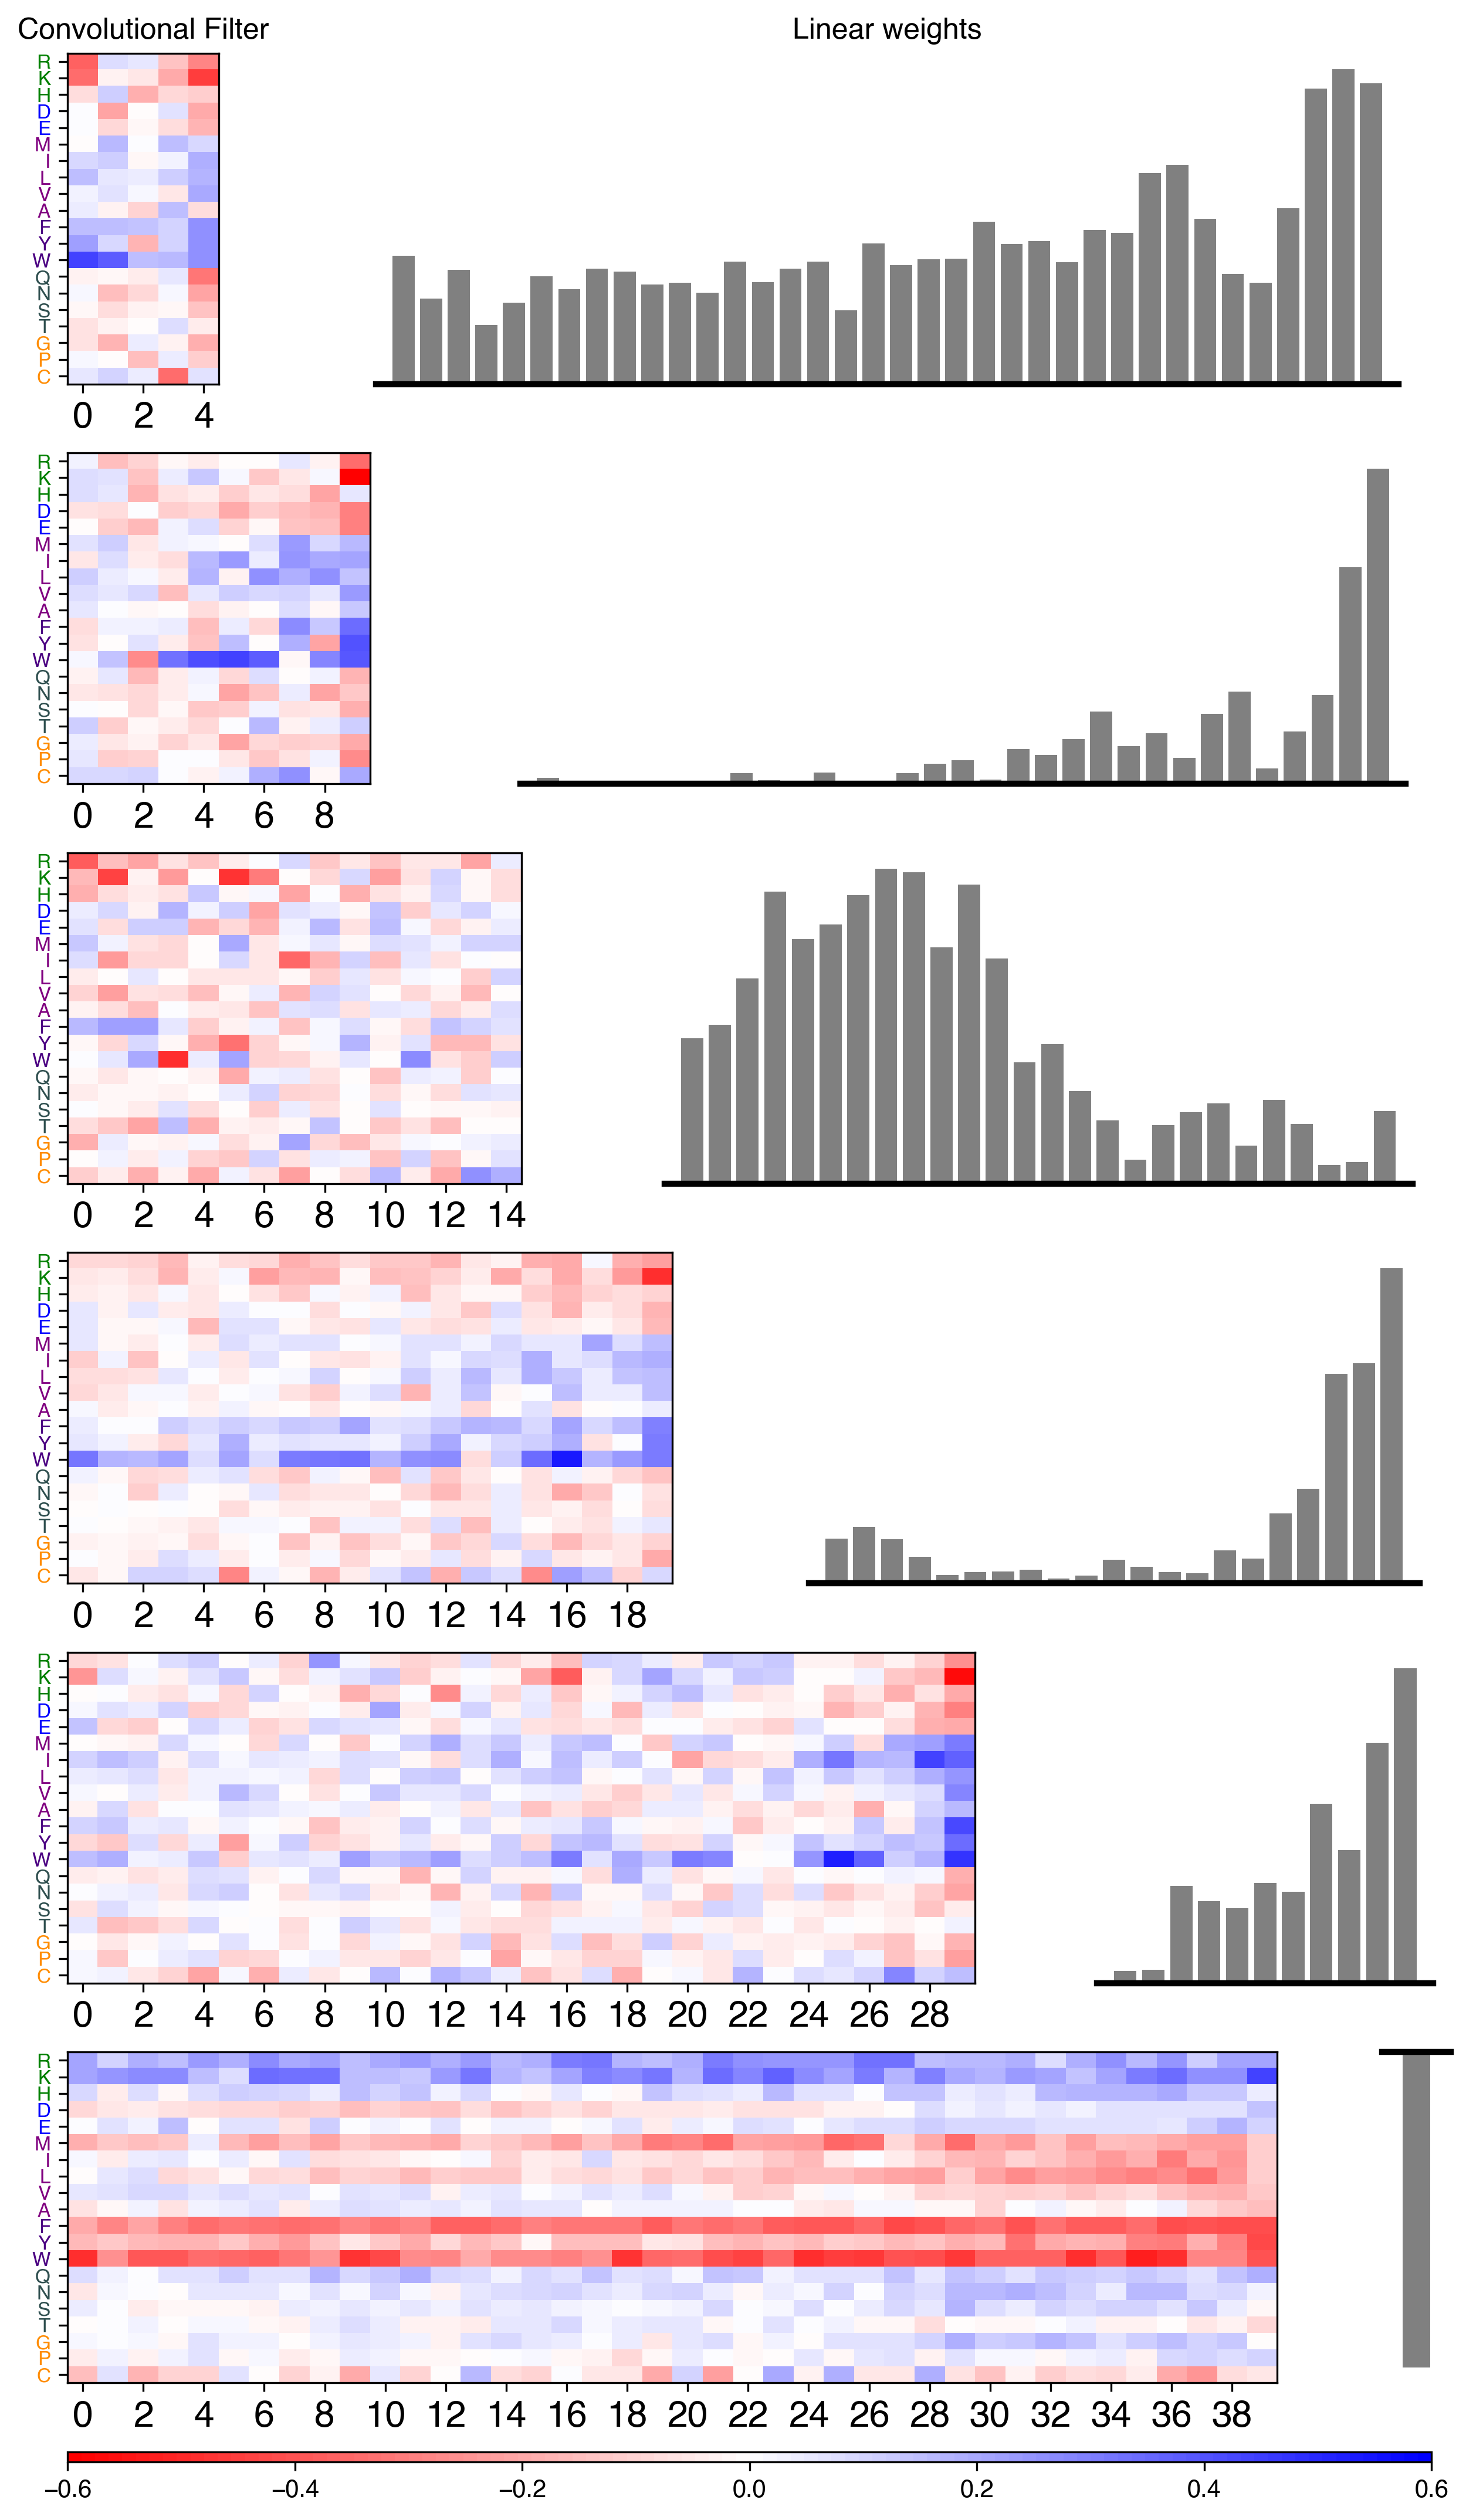

In [387]:
num_rows = 6
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

# lim = max([abs(w) for w in conv_weights])
lim = 0.6

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot_best(fig, 5, model_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

make_row_plot_best(fig, 10, model_10, 3, lim, height_ratios, num_rows)
make_row_plot_best(fig, 15, model_15, 5, lim, height_ratios, num_rows)
make_row_plot_best(fig, 20, model_20, 7, lim, height_ratios, num_rows)
make_row_plot_best(fig, 30, model_30, 9, lim, height_ratios, num_rows)
make_row_plot_best(fig, 40, model_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("../figures/three_state_K1_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


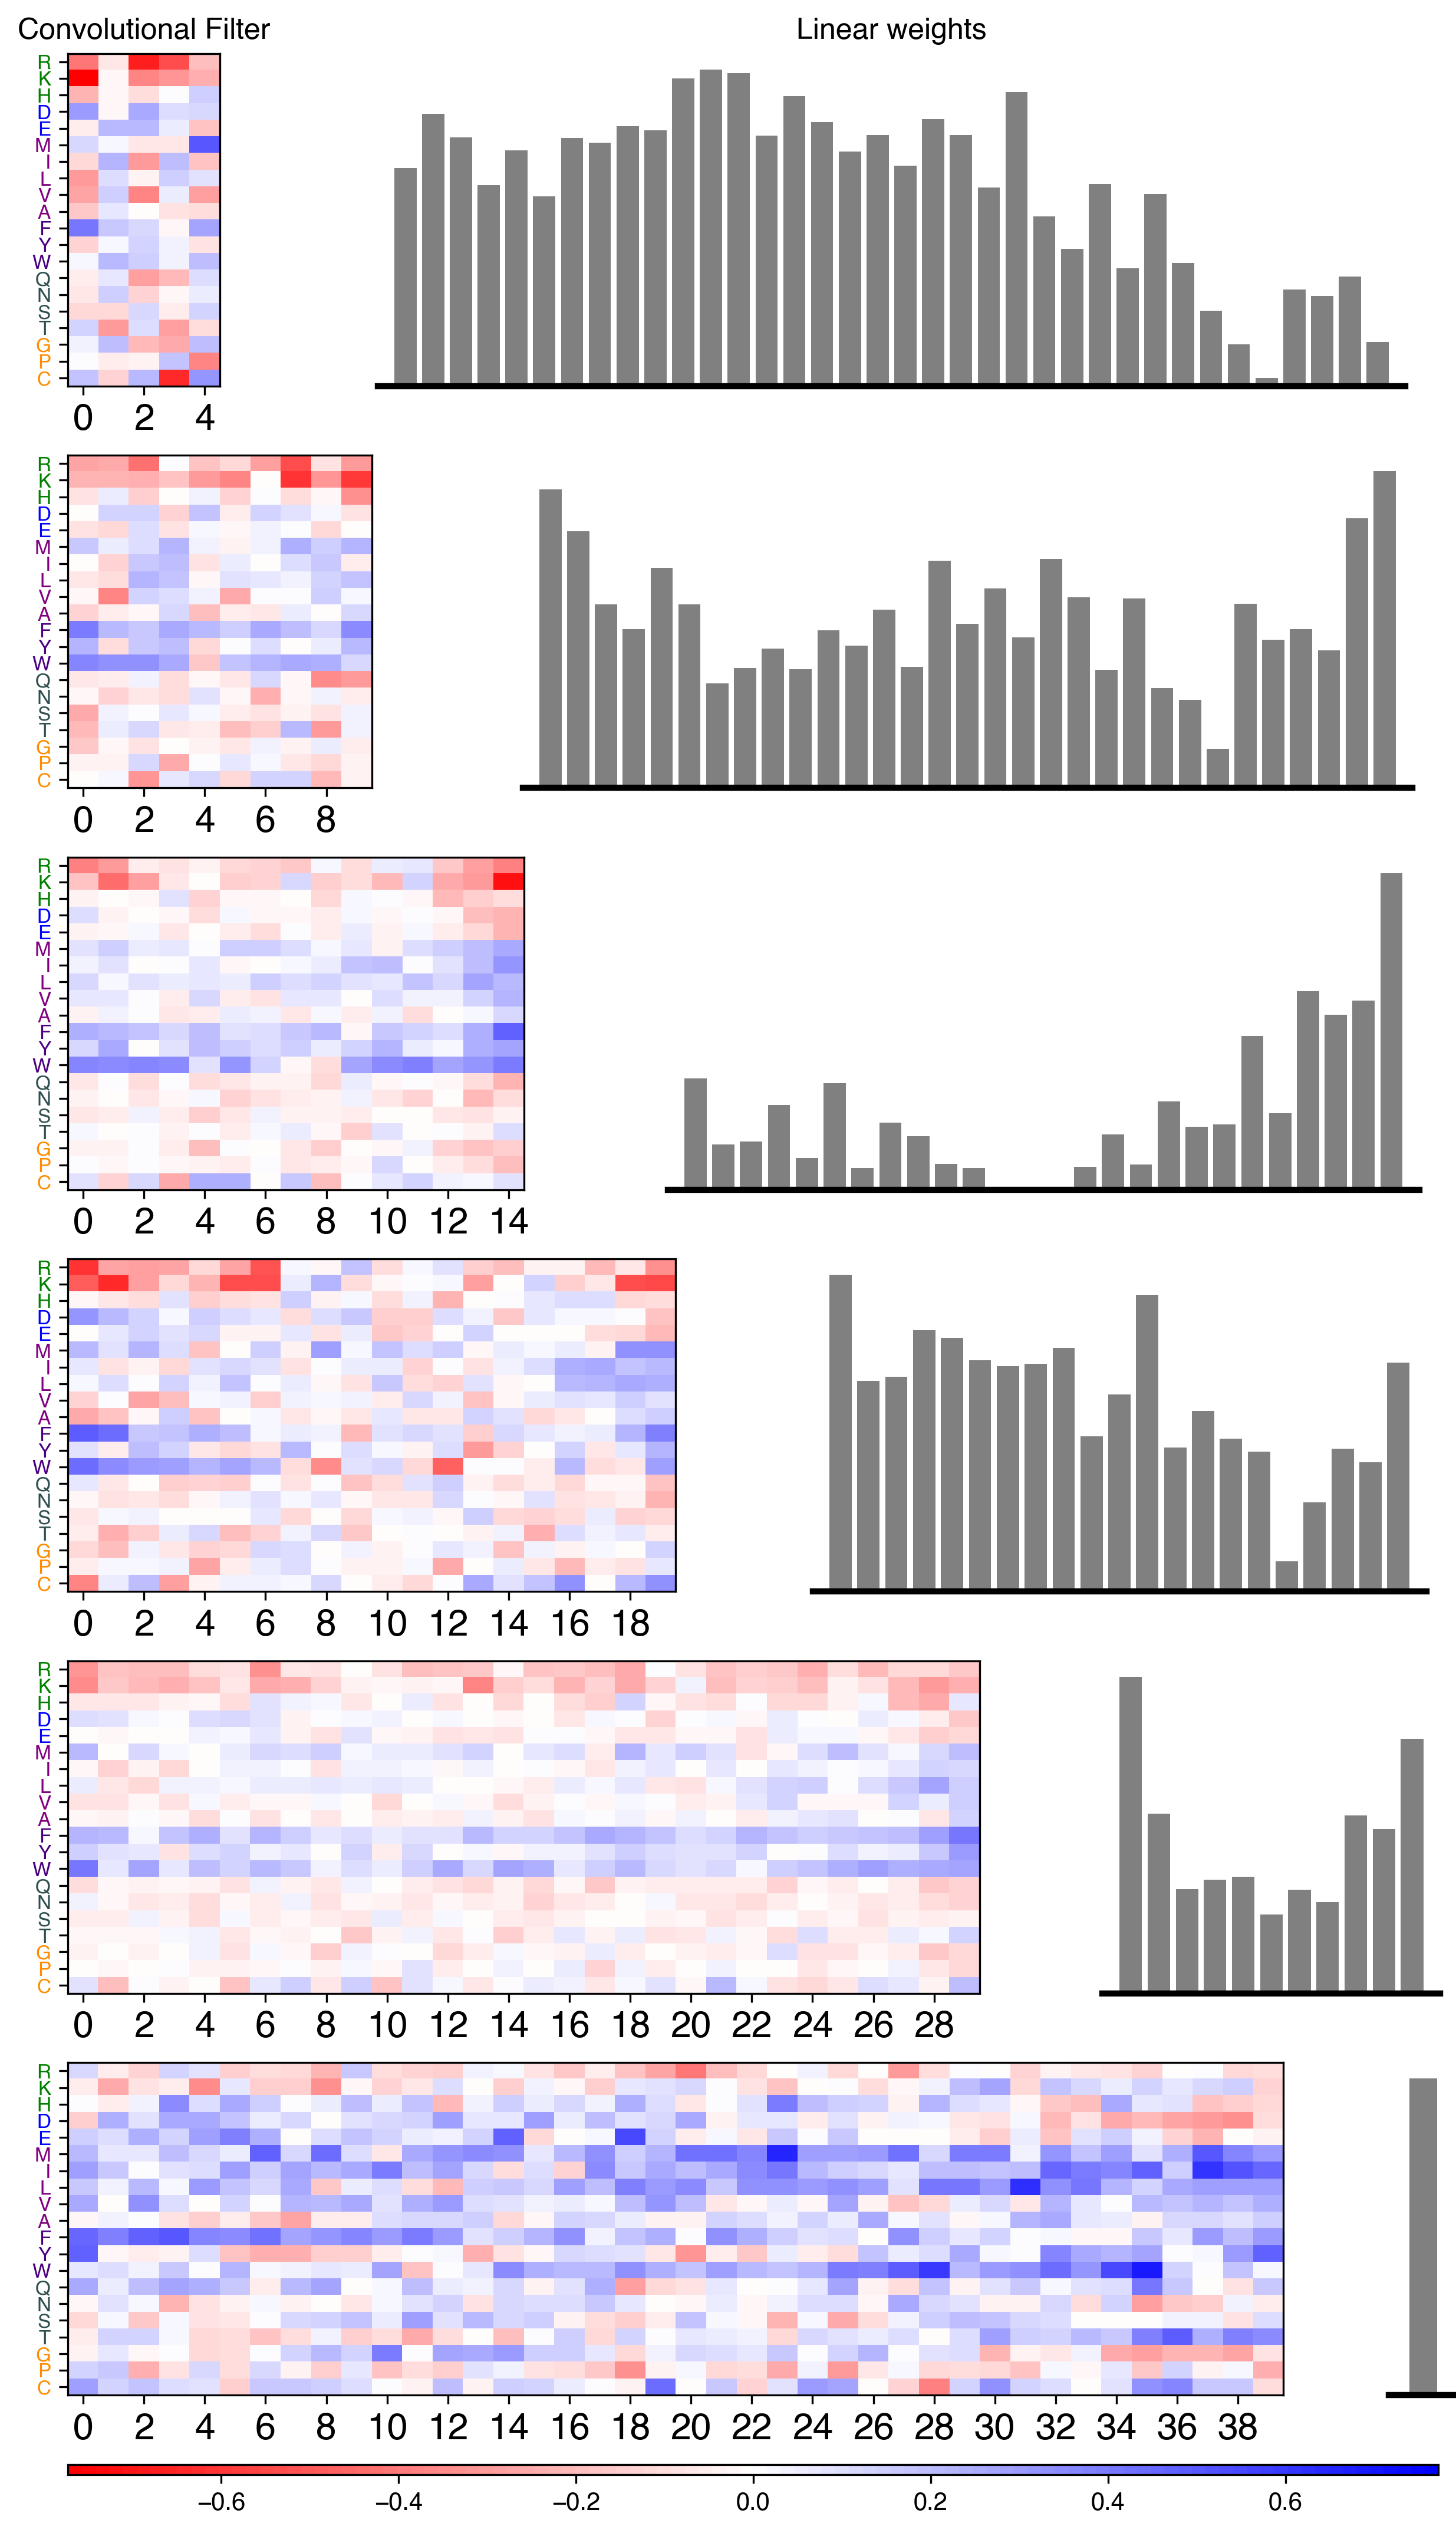

In [388]:
# FOR K2
def make_row_plot_K2(fig, kernel_size, model, row, lim, height_ratios, num_rows):

    model_conv1 = get_conv_weights(model, "conv2.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear2.weight", kernel_size)

    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 


    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)

    ax2.spines['bottom'].set_bounds(min(model_xvals1) - 1, max(model_xvals1) + 1)
    
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1


def get_linear_weights(model, layer, kernel_size):
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals

amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

num_rows = 6
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv2.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])
# lim = 0.6

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot_K2(fig, 5, model_5, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

make_row_plot_K2(fig, 10, model_10, 3, lim, height_ratios, num_rows)
make_row_plot_K2(fig, 15, model_15, 5, lim, height_ratios, num_rows)
make_row_plot_K2(fig, 20, model_20, 7, lim, height_ratios, num_rows)
make_row_plot_K2(fig, 30, model_30, 9, lim, height_ratios, num_rows)
make_row_plot_K2(fig, 40, model_40, 11, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

# plt.savefig("../figures/three_state_K2_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')
